In [562]:
import pandas as pd
import os
import pandas as pd

def print_tests(model, method, print_ = "print"):
    # Directory containing the CSV files
    directory = f"outputs/results/{method}/{model}/"
    
    # Initialize an empty DataFrame to store all data
    combined_df = pd.DataFrame()
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            # Read each CSV file
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            
            # Determine index positions based on the model
            if "roberta" in model:
                lnum_ind = 3
            else: 
                lnum_ind = 2
            
            
            # Add lnum and lname columns
            df["lnum"] = df["parameter"].apply(lambda param: int(param.split(".")[lnum_ind]))
            df["lname"] = df["parameter"].apply(lambda param: param.split(".")[lnum_ind+1] + "." + param.split(".")[lnum_ind+2] + "." + param.split(".")[lnum_ind+3])
            
            # Append the data from this CSV to the combined DataFrame
            combined_df = pd.concat([combined_df, df], ignore_index=True)

    if method == "none":
        combined_df["rate"] = 0

    combined_df = combined_df.drop_duplicates(subset=['parameter', 'rate'])

    if method != "none":
        combined_df["accuracy_increase"] = combined_df["final_top1_accuracy"] - combined_df["edited_top1_accuracy"]
        combined_df["loss_change"] = combined_df["final_loss"] - combined_df["edited_loss"]

    # Reorder columns to move 'lnum', 'lname', and 'rate' to the start
    columns_order = ['lnum', 'lname', 'rate'] + [col for col in combined_df.columns if col not in ['lnum', 'lname', 'rate']]
    combined_df = combined_df[columns_order]

    # Build the nested dictionary structure
    layers = {}

    for i in range(len(combined_df)):
        rate = str(combined_df.iloc[i, 2])
        transformer_block = combined_df.iloc[i, 1]
        layer_number = combined_df.iloc[i, 0]
        
        # Check if the rate key exists
        if rate not in layers:
            layers[rate] = {}
        
        # Check if the transformer block key exists within the rate
        if transformer_block not in layers[rate]:
            layers[rate][transformer_block] = {}
        
        # Assign the layer number within the transformer block
        layers[rate][transformer_block][layer_number] = "y"

    if print_ == "print":
        # Print the structure
        for r, r_val in layers.items():
            print(r)
            for b, b_val in r_val.items():
                print(f"   {b}")
                for l, l_val in b_val.items():
                    print(f"       {l}")

    return combined_df, layers



In [169]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

In [540]:
def plot_metric_vs_layer(df1, df2, metric, plot0 = True):
    fig, axes = plt.subplots(nrows=1, ncols=df1['lname'].nunique(), figsize=(20, 5), sharey=True)
    transformer_blocks = df1['lname'].unique()

    for i, block in enumerate(transformer_blocks):
        ax = axes[i]
        ax2 = ax.twinx()  # Create a secondary y-axis

        for rate, color in zip([0.9, 0.8, 0], colors):
            if rate == 0:
                data = df2[df2['lname'] == block]
                if plot0 == True:
                    ax.scatter(data['lnum'], data[metric], label=f'{rate}% Reduction', color=color)
                else:
                    ax.plot(data['lnum'], data["original_top1_accuracy"], label=f'{rate}% Reduction', color="black", linestyle = "--", linewidth = 1)
            else:
                data = df1[(df1['lname'] == block) & (df1['rate'] == rate)]
                #ax2.plot(data['lnum'], data['norm'] / data['lnum'], label=f'{rate * 100}% Reduction Norm', color=color, linestyle='--')
                #ax2.plot(data['lnum'], data['norm'], label=f'{rate * 100}% Reduction Norm', color=color, linestyle='--')
                ax.scatter(data['lnum'], data[metric], label=f'{rate}% Reduction', color=color)


        ax.set_title(f'Transformer Block: {block}')
        ax.set_xlabel('Layer Number')

        if i == len(transformer_blocks) - 1:
            ax2.set_ylabel('Difference matrix F-norm / layer number', labelpad=15)
            ax2.yaxis.set_label_position("right") 

        if i == 0:
            if metric == "final_top1_accuracy":
                ax.set_ylabel('Final Top-1 Accuracy')
            elif metric == "edited_top1_accuracy":
                ax.set_ylabel('Edited Model Top-1 Accuracy')
            elif metric == "edited_loss":
                ax.set_ylabel('Edited Model Loss')
            elif metric == "final_loss":
                ax.set_ylabel('Final Model Loss')
            if metric == "final_top10_accuracy":
                ax.set_ylabel('Final Top-10 Accuracy')
            elif metric == "edited_top10_accuracy":
                ax.set_ylabel('Edited Model Top-10 Accuracy')
        ax.legend()

    plt.tight_layout()
    plt.show()

In [549]:
def plot_final_accuracy_vs_norm_filtered(df1, df2, first_layers_to_remove=0, last_layers_to_remove=0):
    fig, axes = plt.subplots(nrows=1, ncols=df1['lname'].nunique(), figsize=(20, 5), sharey=True)
    transformer_blocks = df1['lname'].unique()

    for i, block in enumerate(transformer_blocks):
        ax = axes[i]
        
        for rate, color in zip([0.9, 0.8], colors):
            data = df1[(df1['lname'] == block) & (df1['rate'] == rate)]
            
            # Filter out the first and last few layers
            max_layer_num = data['lnum'].max()
            min_layer_num = data['lnum'].min()
            data_filtered = data[(data['lnum'] > min_layer_num + first_layers_to_remove) & 
                                 (data['lnum'] < max_layer_num - last_layers_to_remove)]
            
            ax.scatter(data_filtered['norm'], data_filtered['final_top1_accuracy'], label=f'{rate*100}% Reduction', color=color)

        ax.set_title(f'Transformer Block: {block}')
        ax.set_xlabel('Norm')
        if i == 0:
            ax.set_ylabel('Final Accuracy')
        ax.legend()

    plt.tight_layout()
    plt.show()



In [550]:
def plot_final_accuracy_vs_relative_error(df1, df2):
    fig, axes = plt.subplots(nrows=1, ncols=df1['lname'].nunique(), figsize=(20, 5), sharey=True)
    transformer_blocks = df1['lname'].unique()

    for i, block in enumerate(transformer_blocks):
        ax = axes[i]
        for rate, color in zip([0.9, 0.8], colors):
            if rate == 0:
                data = df2[df2['lname'] == block]
            else:
                data = df1[(df1['lname'] == block) & (df1['rate'] == rate)]
            ax.scatter(data['relative_error'], data['final_top1_accuracy'], label=f'{rate}% Reduction', color=color)

        ax.set_title(f'Transformer Block: {block}')
        ax.set_xlabel('Relative Error')
        if i == 0:
            ax.set_ylabel('Final Accuracy')
        ax.legend()

    plt.tight_layout()
    plt.show()



In [551]:
def plot_final_vs_edited_accuracy(df1):
    fig, axes = plt.subplots(nrows=1, ncols=df1['lname'].nunique(), figsize=(20, 5), sharey=True)
    transformer_blocks = df1['lname'].unique()

    for i, block in enumerate(transformer_blocks):
        ax = axes[i]

        for rate, color in zip([0.9, 0.8], colors):
            data = df1[(df1['lname'] == block) & (df1['rate'] == rate)]
            ax.scatter(data['edited_loss'], data['final_loss'], label=f'{rate * 100}% Reduction', color=color, alpha=0.7)

        ax.set_xlabel('Edited Accuracy (Top-1)')
        ax.set_ylabel('Final Accuracy (Top-1)')
        ax.set_title('Final Accuracy vs. Edited Accuracy')
        ax.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

In [567]:
df2, layers = print_tests("pythia410m", "none")
df1, layers = print_tests("pythia410m", "lr")

0
   mlp.dense_4h_to_h.weight
       13
       14
       15
       16
       0
       7
       1
       8
       2
       9
       10
       3
       4
       12
       5
       6
   attention.query_key_value.weight
       0
       1
       2
       3
       4
       5
       6
       7
       8
       9
       10
       11
       12
       13
       14
       15
       16
       17
       18
       19
       20
       21
       22
       23
   attention.dense.weight
       19
       20
       21
       22
       23
       0
       1
       2
       3
       4
       5
       6
       7
       8
       9
       10
       11
       12
       13
       14
       15
       16
       17
       18
   mlp.dense_h_to_4h.weight
       1
       2
       3
       0
0.9
   mlp.dense_4h_to_h.weight
       0
       1
       2
       3
       4
       5
       6
       7
       8
       9
       10
       11
       12
       13
       14
       15
       16
       17
       18
       19
       20
  

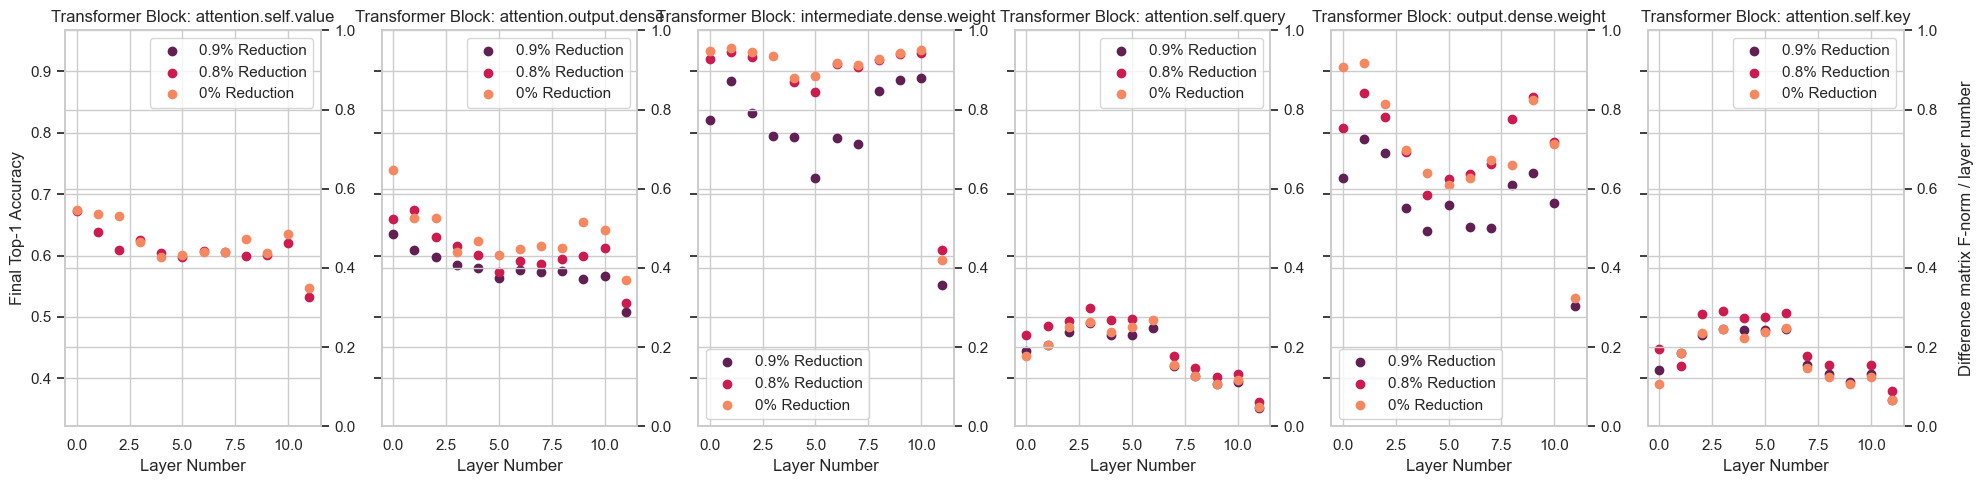

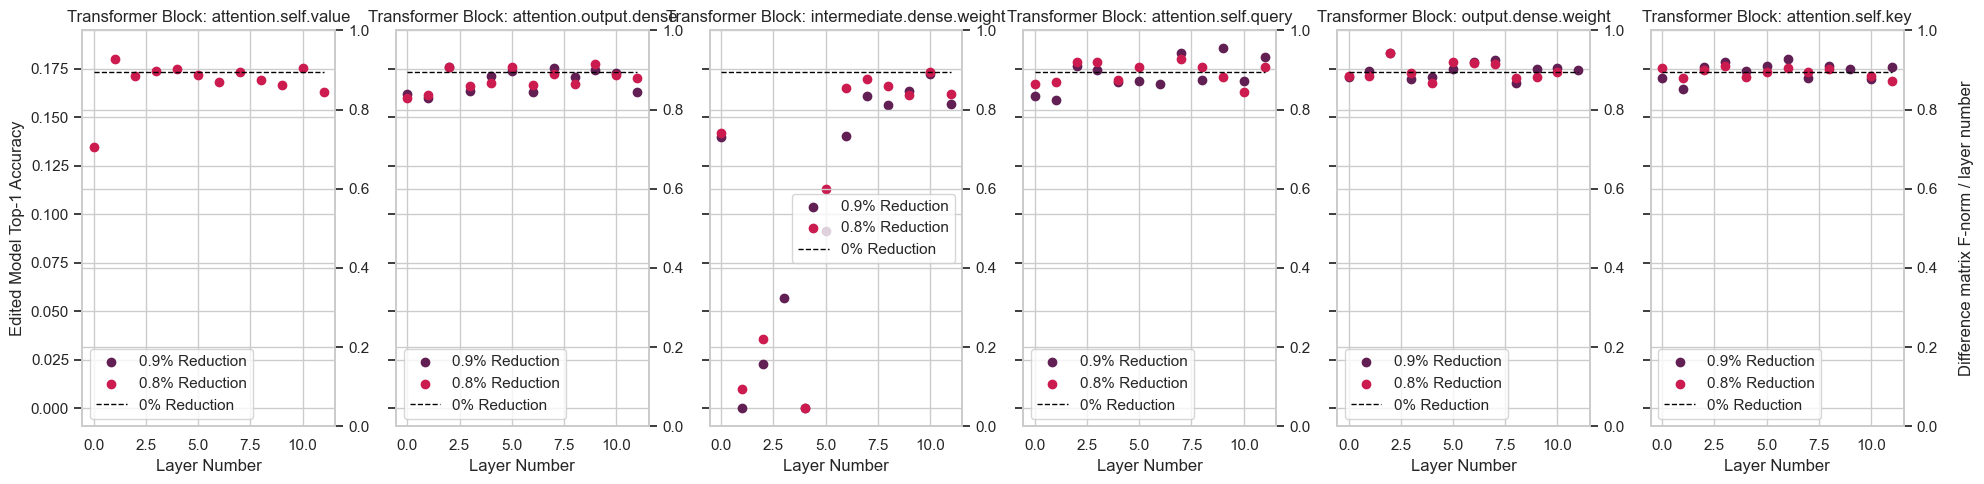

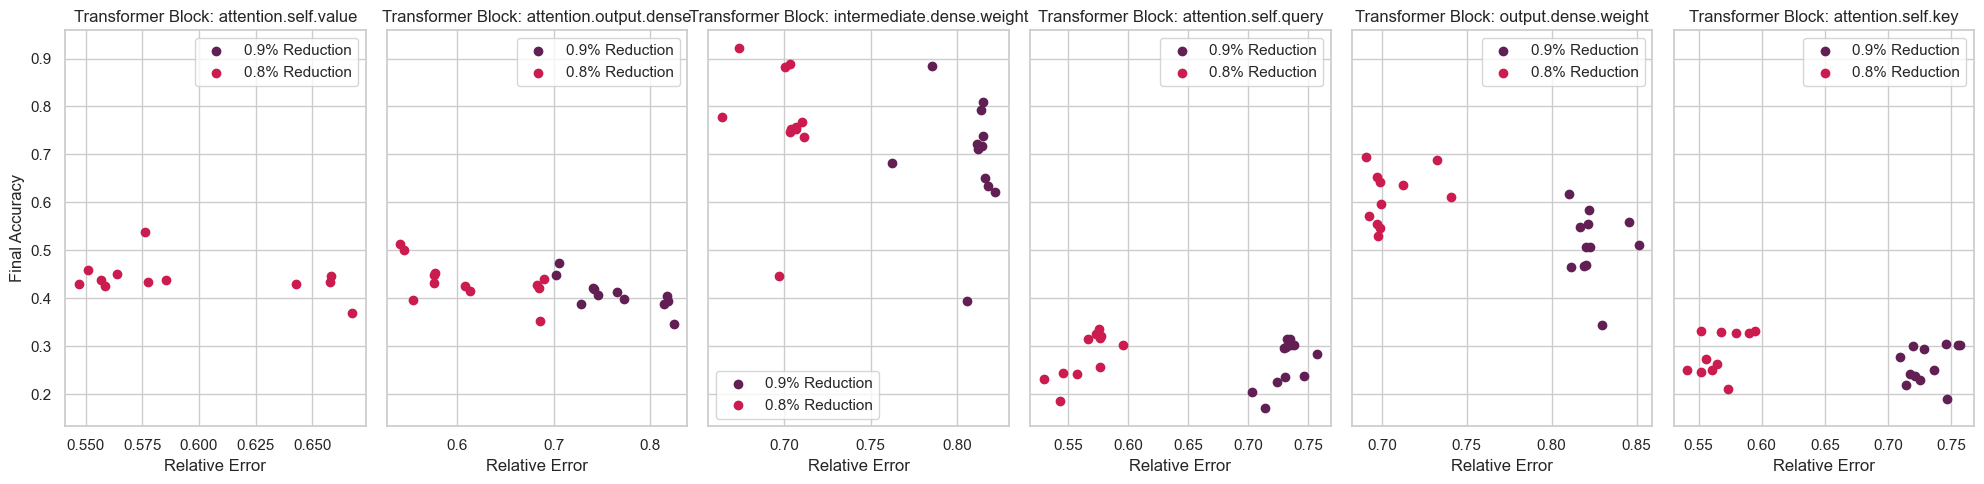

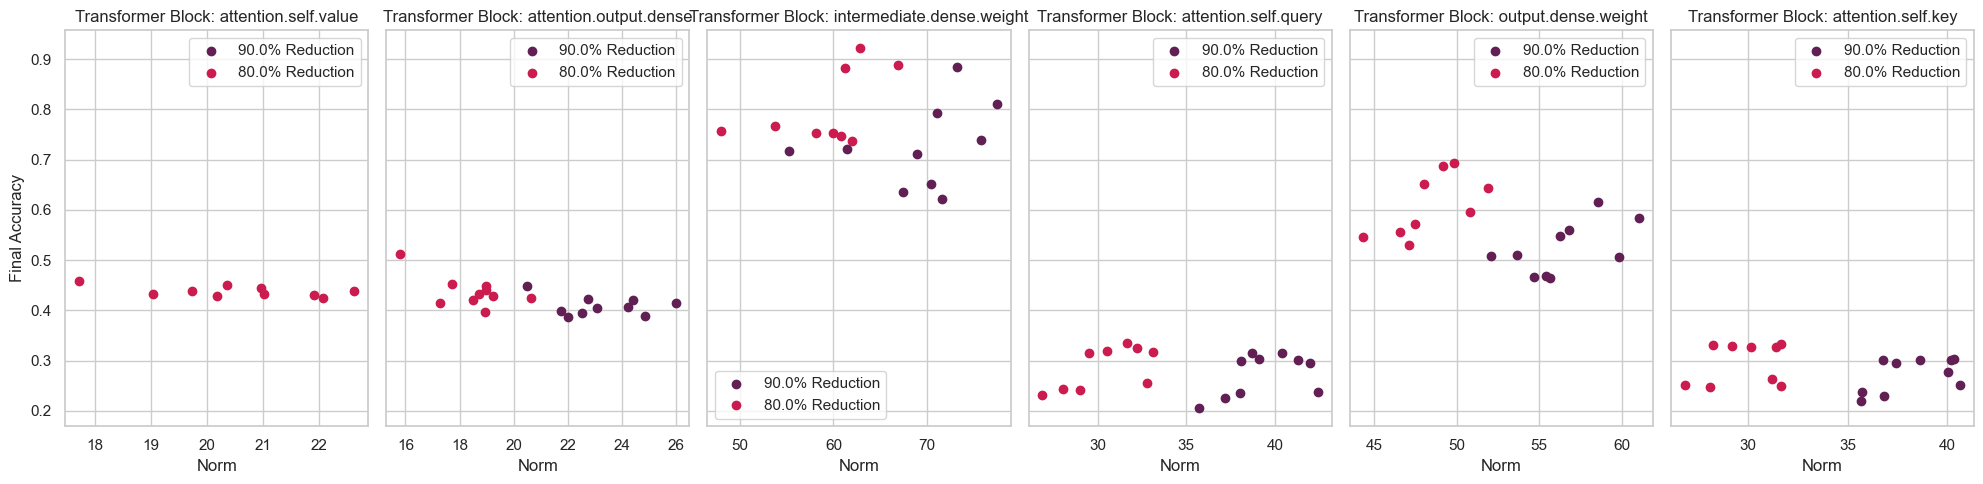

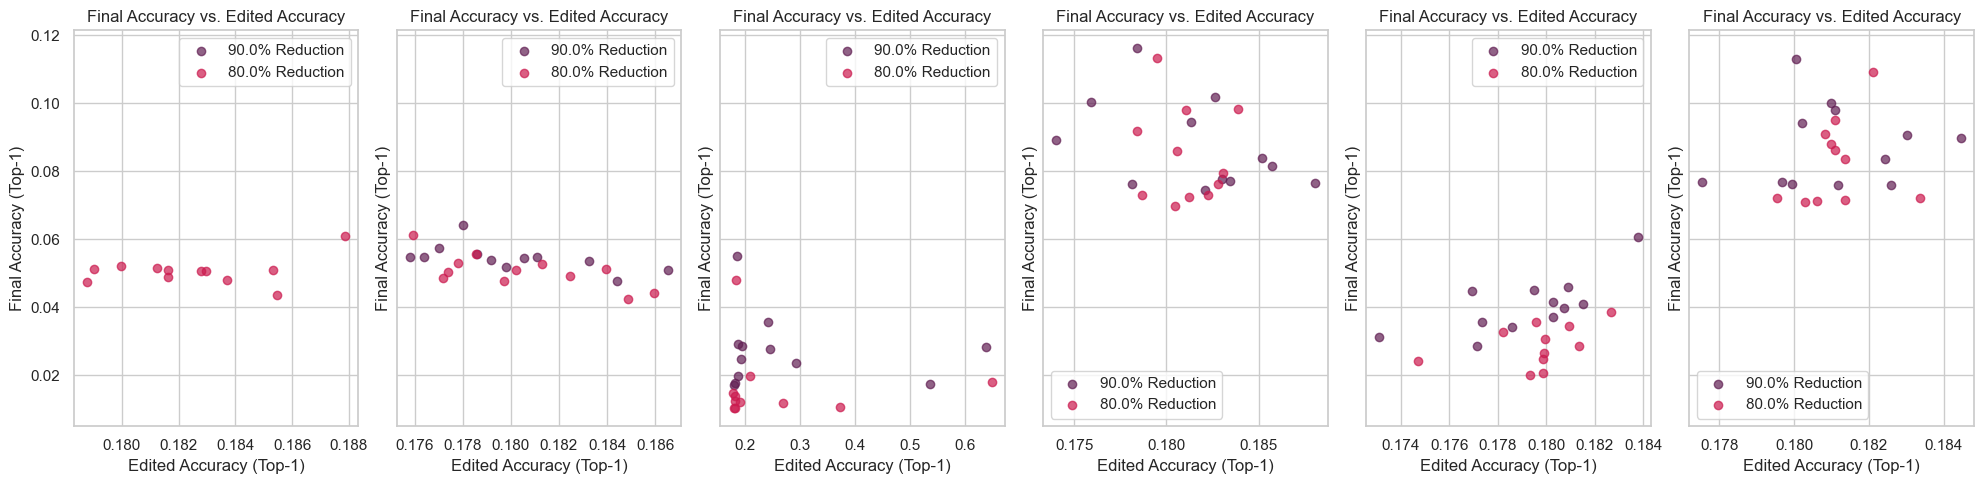

In [558]:
df2, layers = print_tests("roberta_base", "none", "no")
df1, layers = print_tests("roberta_base", "lr", "no")

plot_metric_vs_layer(df1, df2, "final_top1_accuracy")
plot_metric_vs_layer(df1, df2, "edited_top1_accuracy", False)
plot_final_accuracy_vs_relative_error(df1, df2)
plot_final_accuracy_vs_norm_filtered(df1, df2)

plot_final_vs_edited_accuracy(df1)

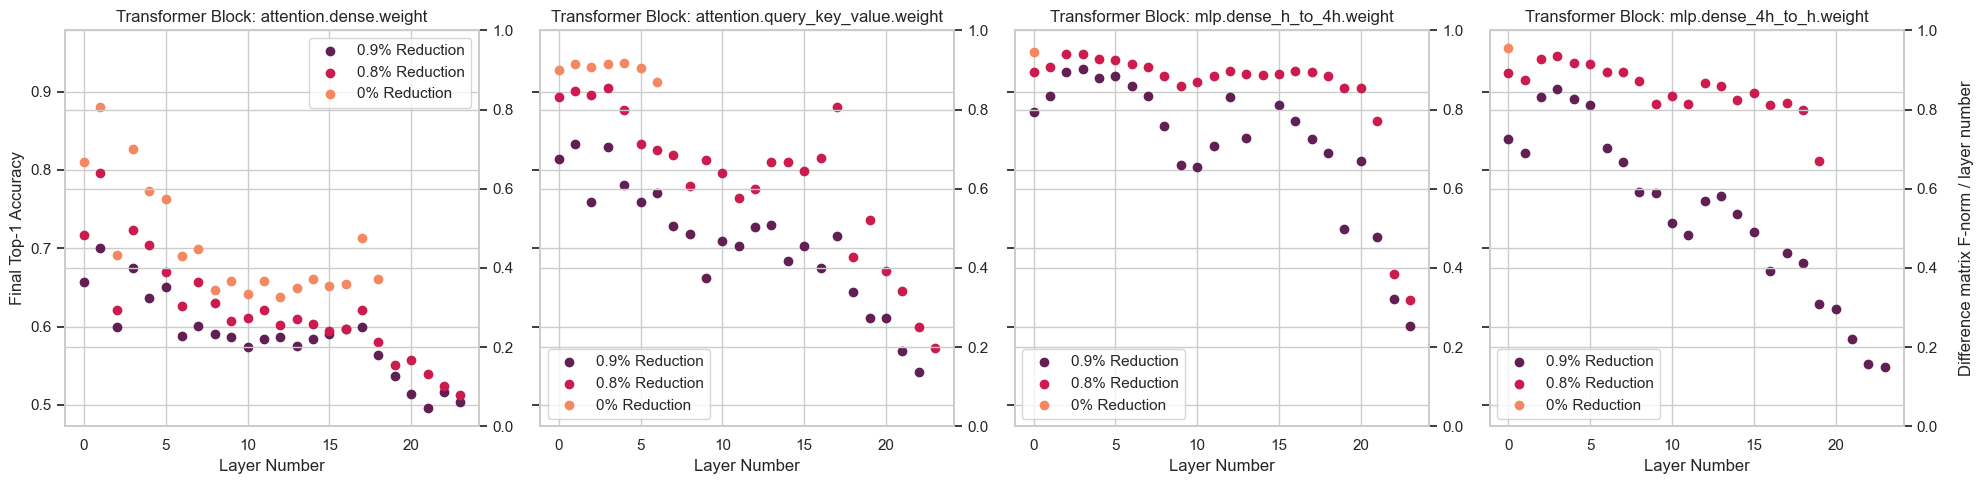

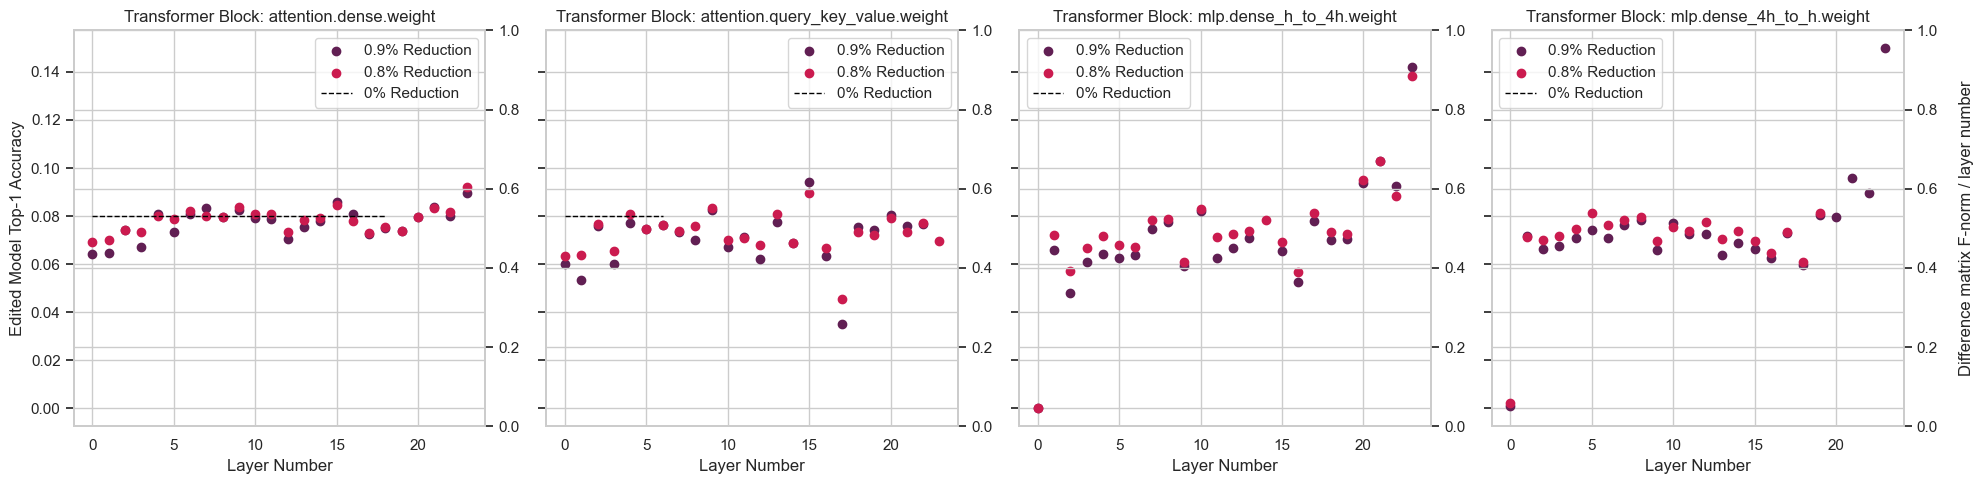

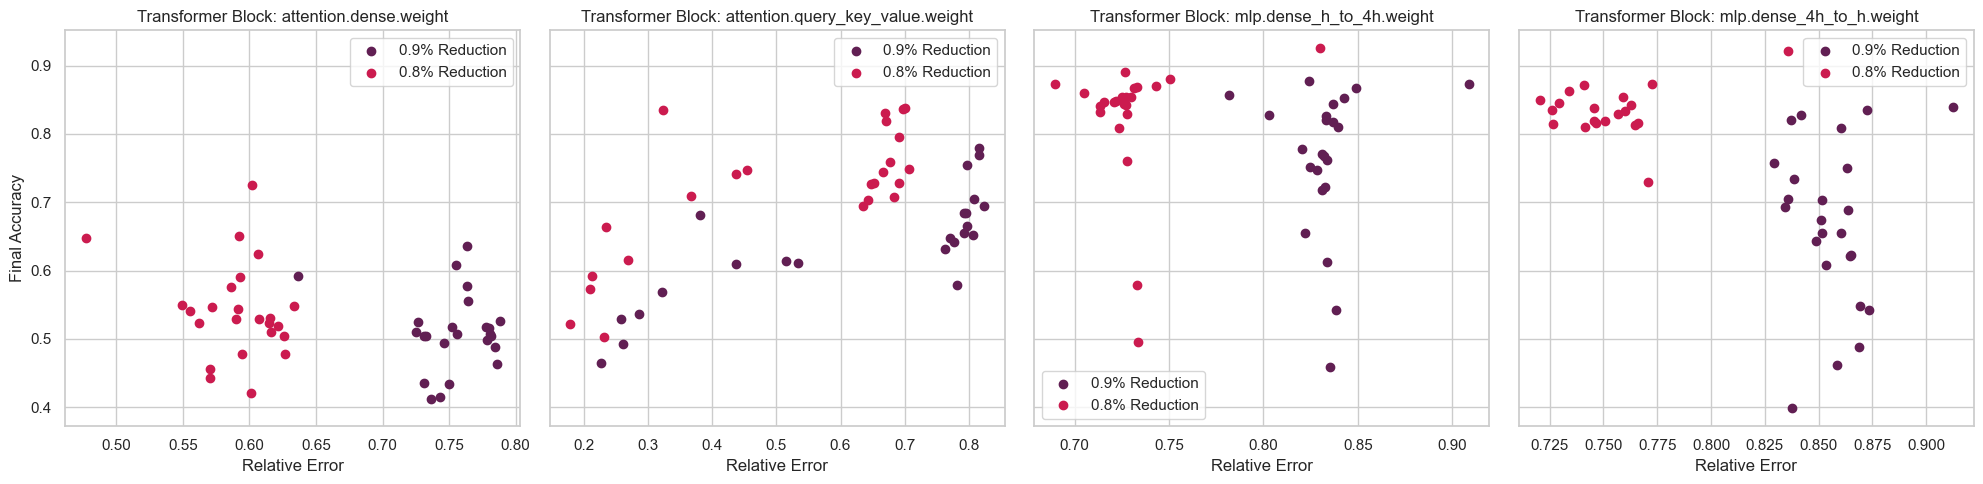

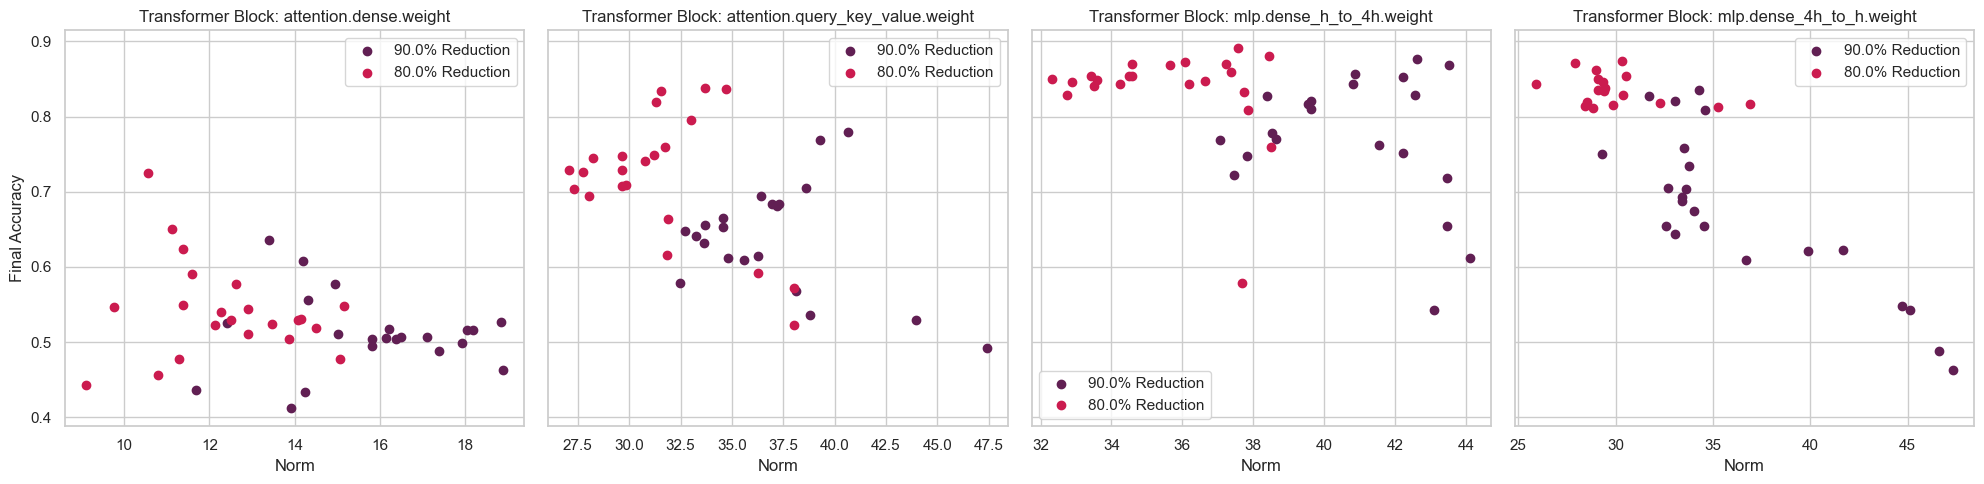

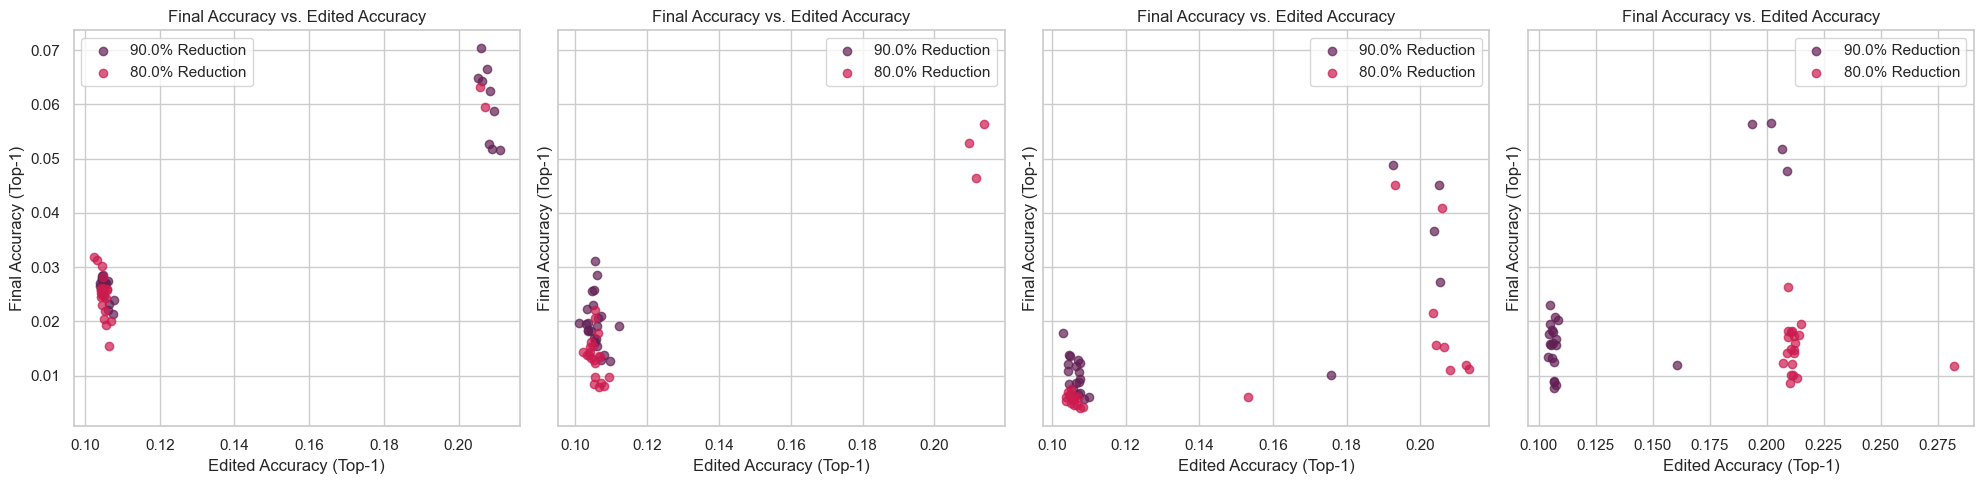

In [559]:
df1, layers = print_tests("pythia410m", "lr", "no")
df2, layers = print_tests("pythia410m", "none", "no")

plot_metric_vs_layer(df1, df2, "final_top1_accuracy")
plot_metric_vs_layer(df1, df2, "edited_top1_accuracy", False)
plot_final_accuracy_vs_relative_error(df1, df2)
plot_final_accuracy_vs_norm_filtered(df1, df2)

plot_final_vs_edited_accuracy(df1)

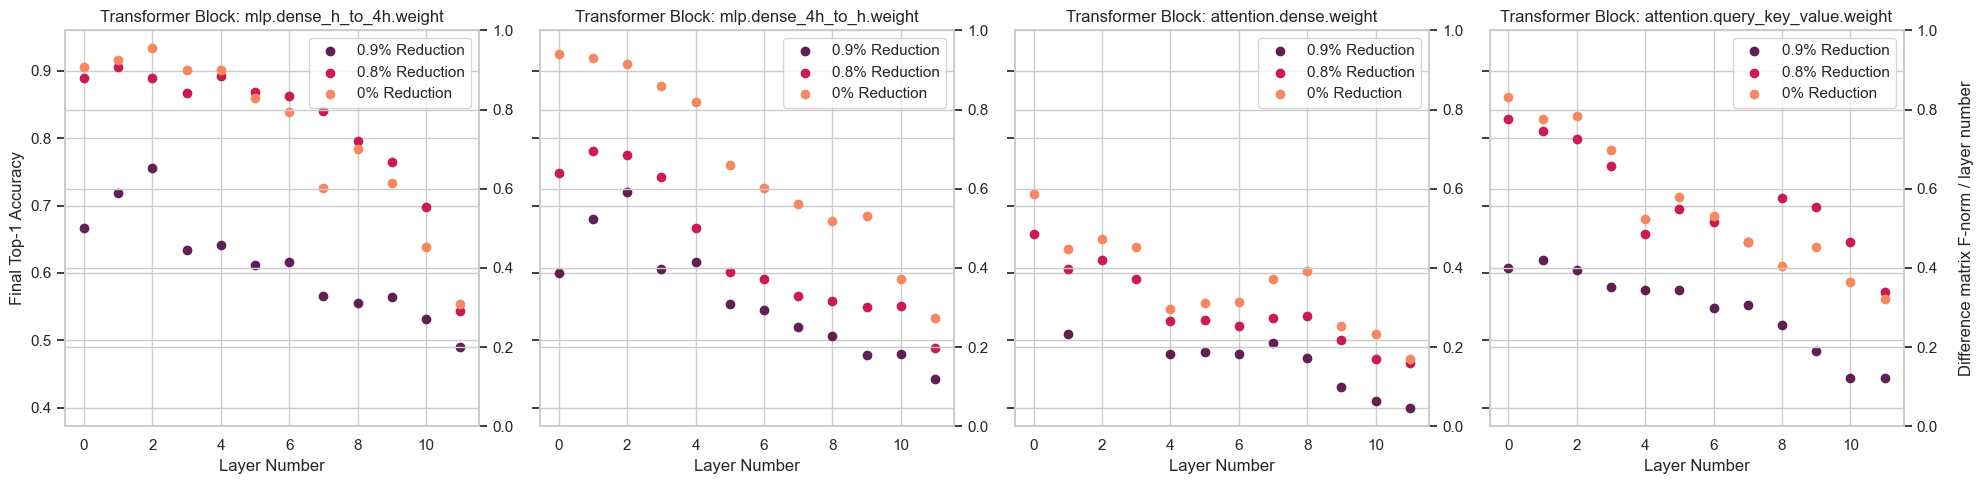

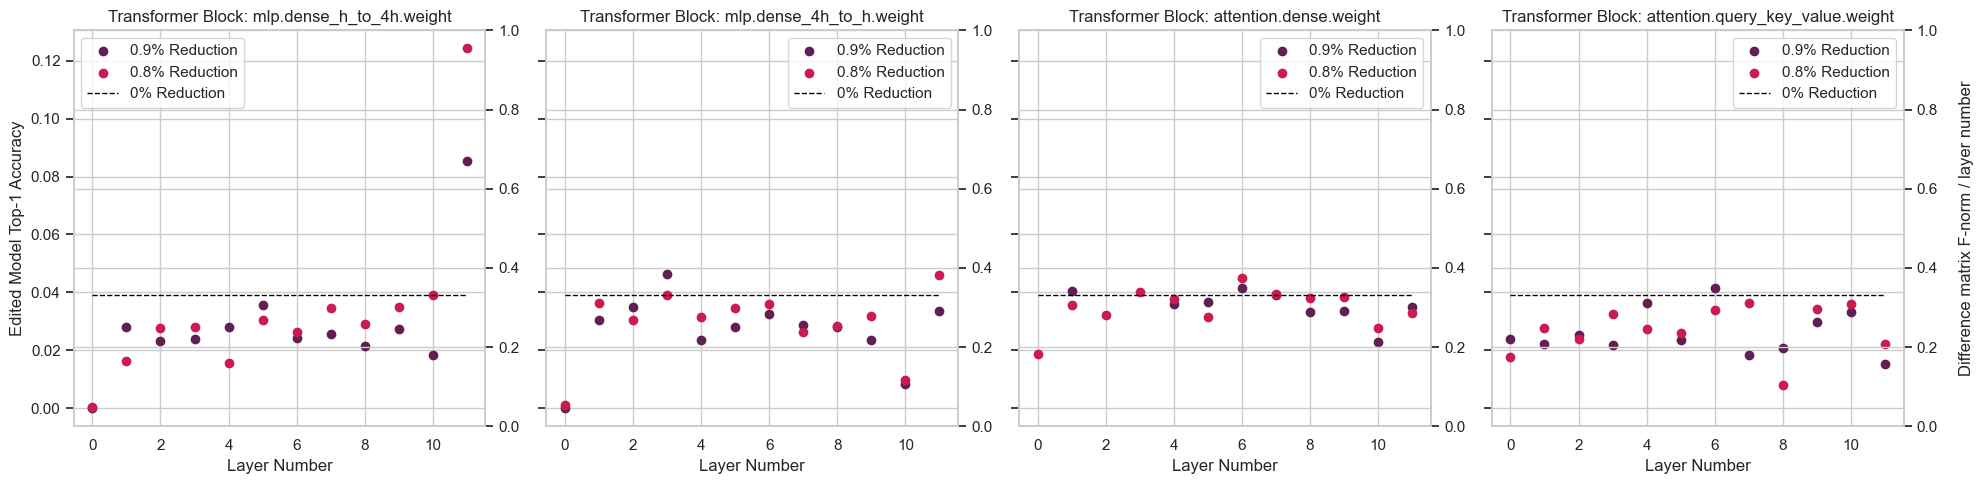

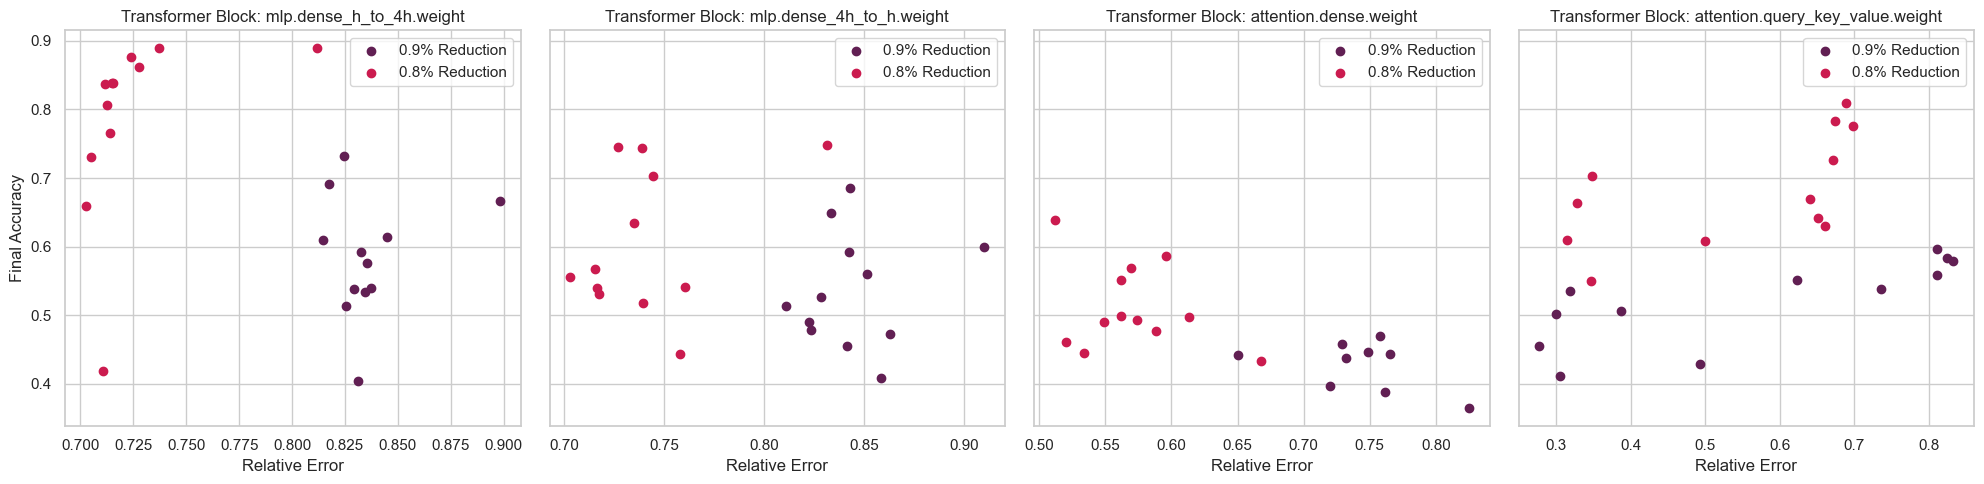

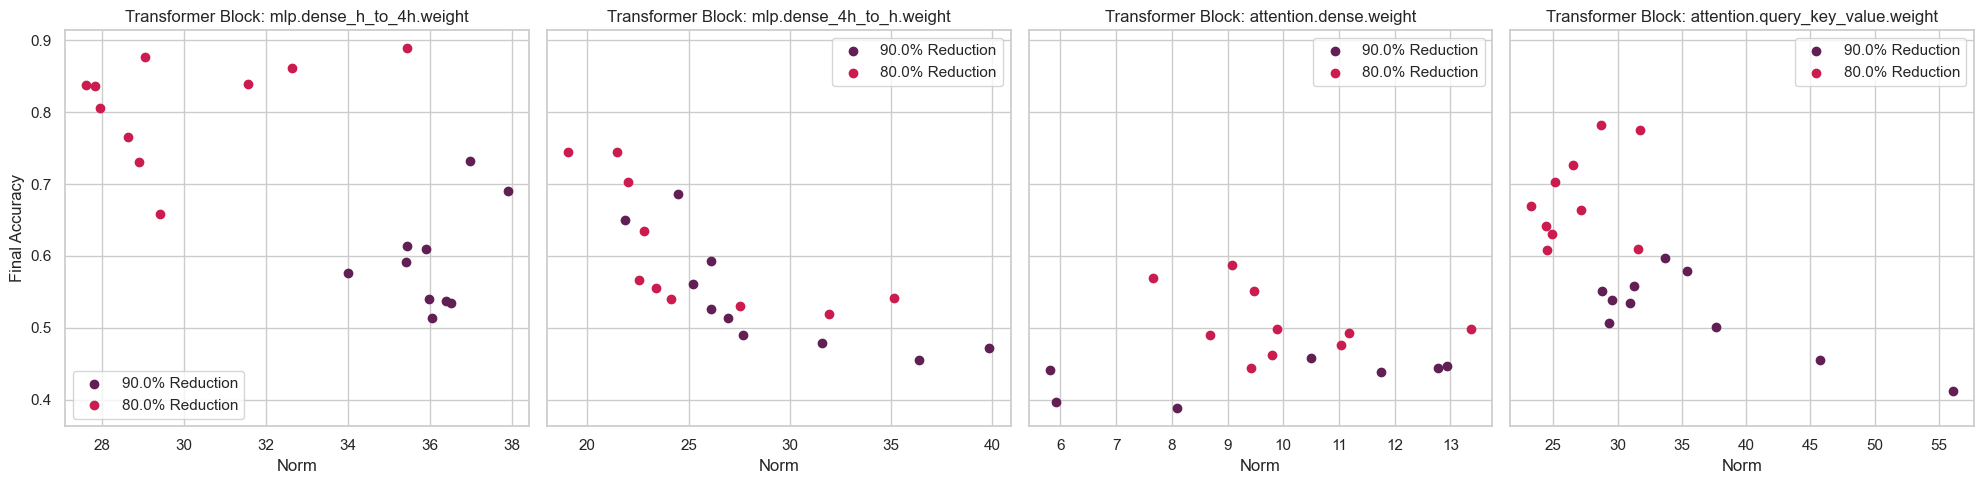

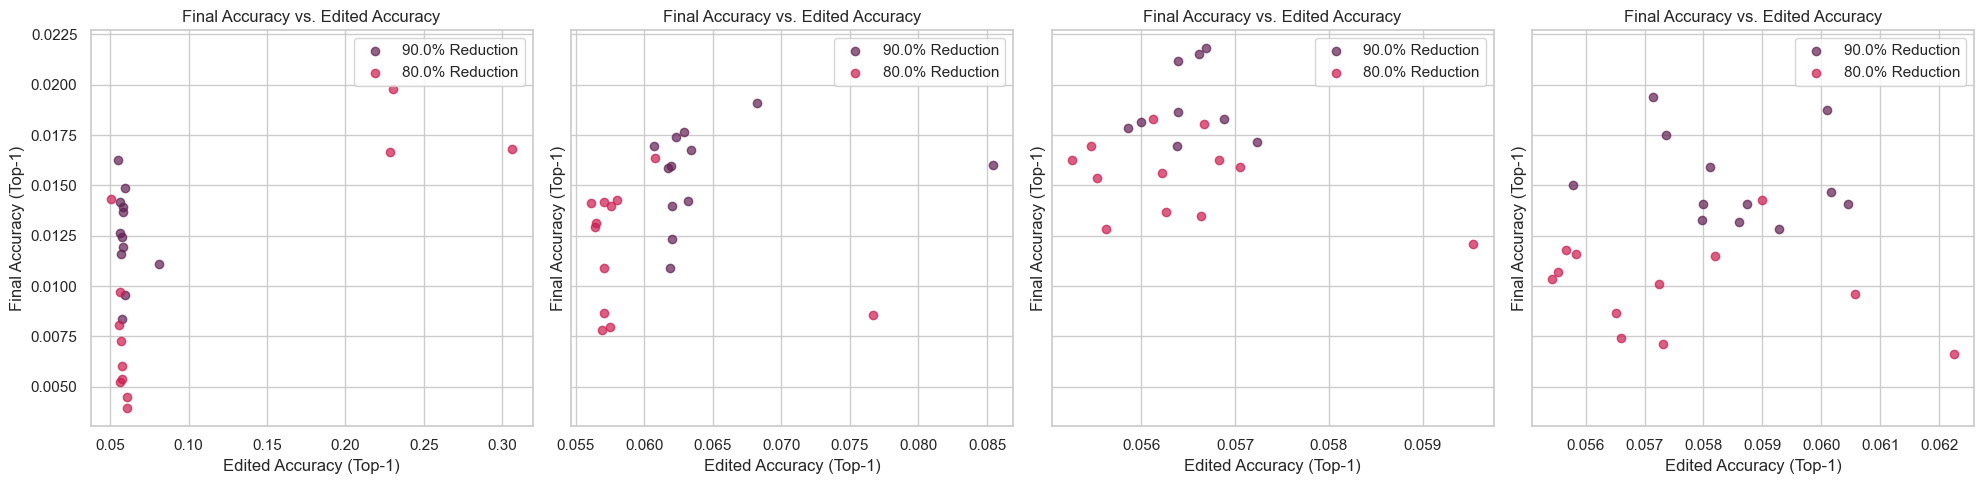

In [560]:
df2, layers2 = print_tests("pythia160m", "none", "no")
df1, layers1 = print_tests("pythia160m", "lr", "no")

plot_metric_vs_layer(df1, df2, "final_top1_accuracy")
plot_metric_vs_layer(df1, df2, "edited_top1_accuracy", False)
plot_final_accuracy_vs_relative_error(df1, df2)
plot_final_accuracy_vs_norm_filtered(df1, df2)

plot_final_vs_edited_accuracy(df1)

In [547]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn style for muted colors
sns.set(style="whitegrid")
sns.set_palette("muted")

# Custom color palette for the plots
colors = sns.color_palette("rocket", 3)  # Using 3 shades of reddish-purple

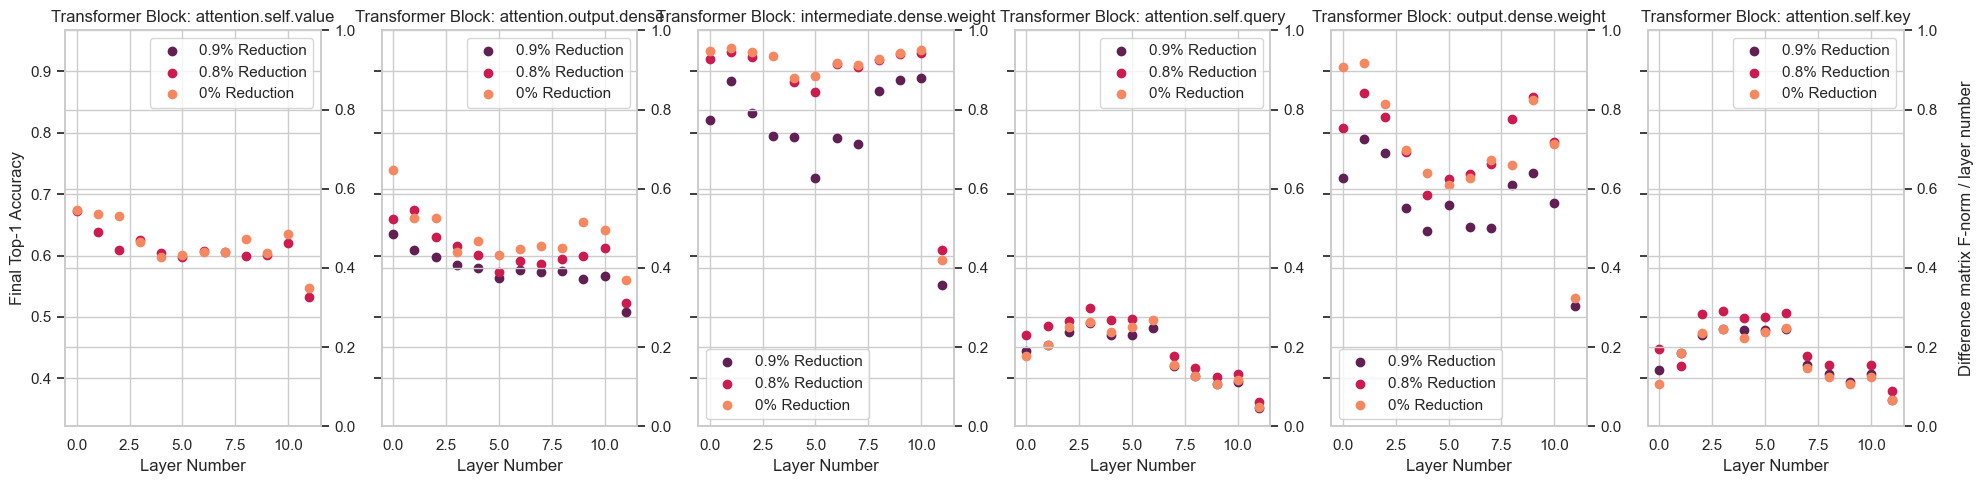

In [460]:
plot_metric_vs_layer(df1, df2, "final_top1_accuracy")

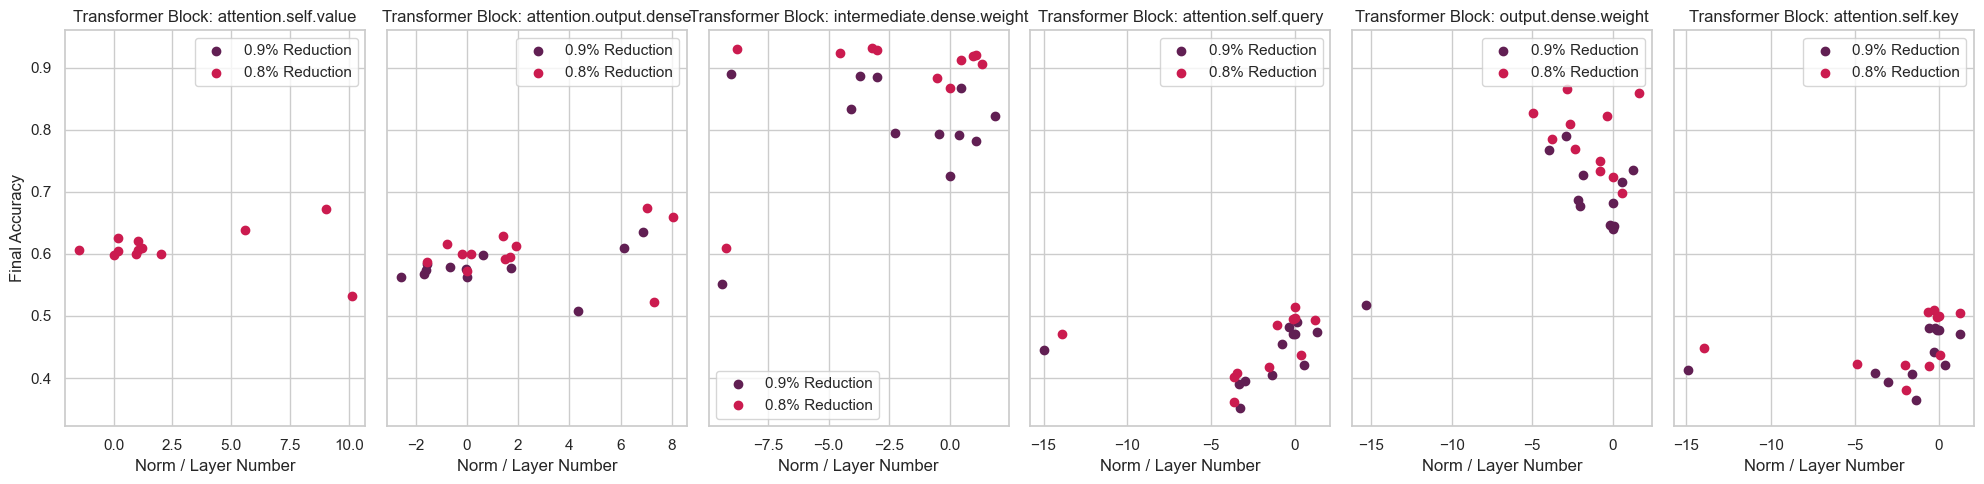

In [557]:
def plot_final_accuracy_vs_norm_per_layer(df1, df2):
    fig, axes = plt.subplots(nrows=1, ncols=df1['lname'].nunique(), figsize=(20, 5), sharey=True)
    transformer_blocks = df1['lname'].unique()

    for i, block in enumerate(transformer_blocks):
        ax = axes[i]
        for rate, color in zip([0.9, 0.8], colors):
            data = df1[(df1['lname'] == block) & (df1['rate'] == rate)]
            mean = data["norm"].mean()
            std = data["norm"].std()

            col = (data["norm"] - mean) / std
            ax.scatter(col * (data["lnum"]-5), data['final_top1_accuracy'], label=f'{rate}% Reduction', color=color)

        ax.set_title(f'Transformer Block: {block}')
        ax.set_xlabel('Norm / Layer Number')
        if i == 0:
            ax.set_ylabel('Final Accuracy')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_final_accuracy_vs_norm_per_layer(df1, df2)


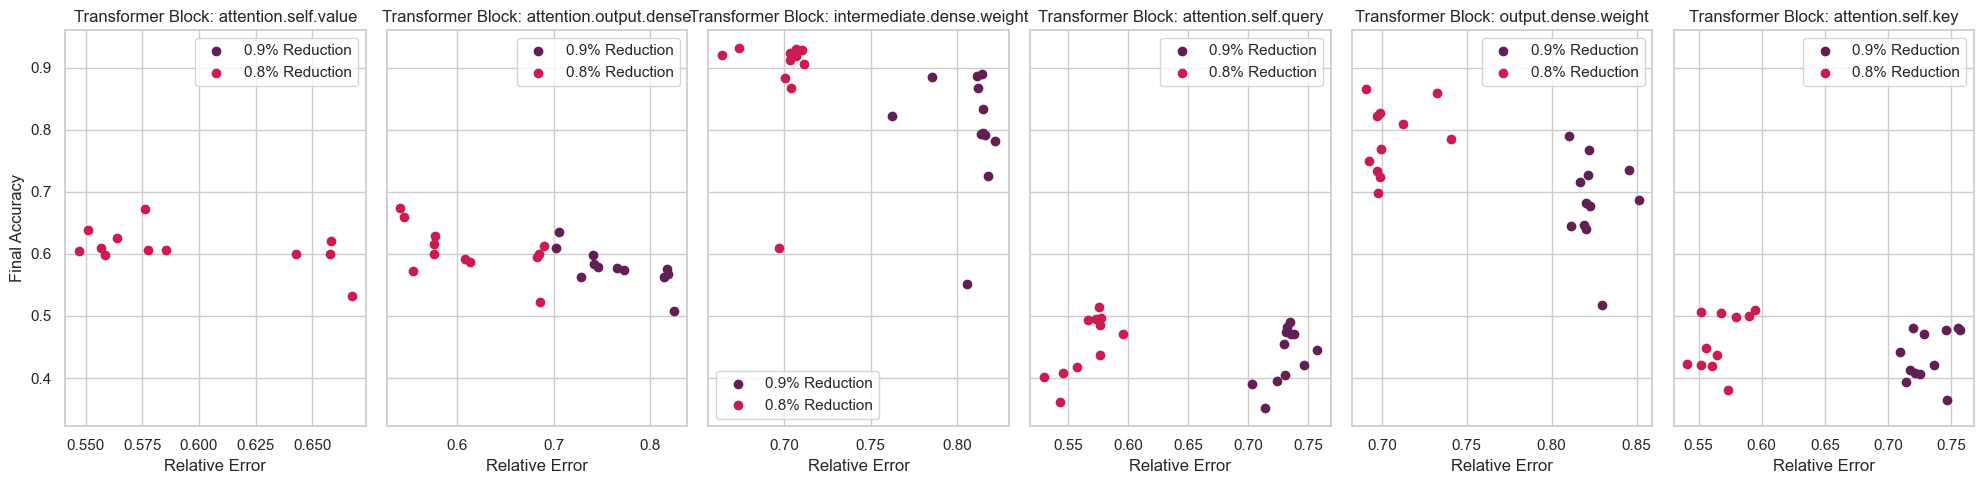

In [458]:
def plot_final_accuracy_vs_relative_error(df1, df2):
    fig, axes = plt.subplots(nrows=1, ncols=df1['lname'].nunique(), figsize=(20, 5), sharey=True)
    transformer_blocks = df1['lname'].unique()

    for i, block in enumerate(transformer_blocks):
        ax = axes[i]
        for rate, color in zip([0.9, 0.8], colors):
            if rate == 0:
                data = df2[df2['lname'] == block]
            else:
                data = df1[(df1['lname'] == block) & (df1['rate'] == rate)]
            ax.scatter(data['relative_error'], data['final_top1_accuracy'], label=f'{rate}% Reduction', color=color)

        ax.set_title(f'Transformer Block: {block}')
        ax.set_xlabel('Relative Error')
        if i == 0:
            ax.set_ylabel('Final Accuracy')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_final_accuracy_vs_relative_error(df1, df2)


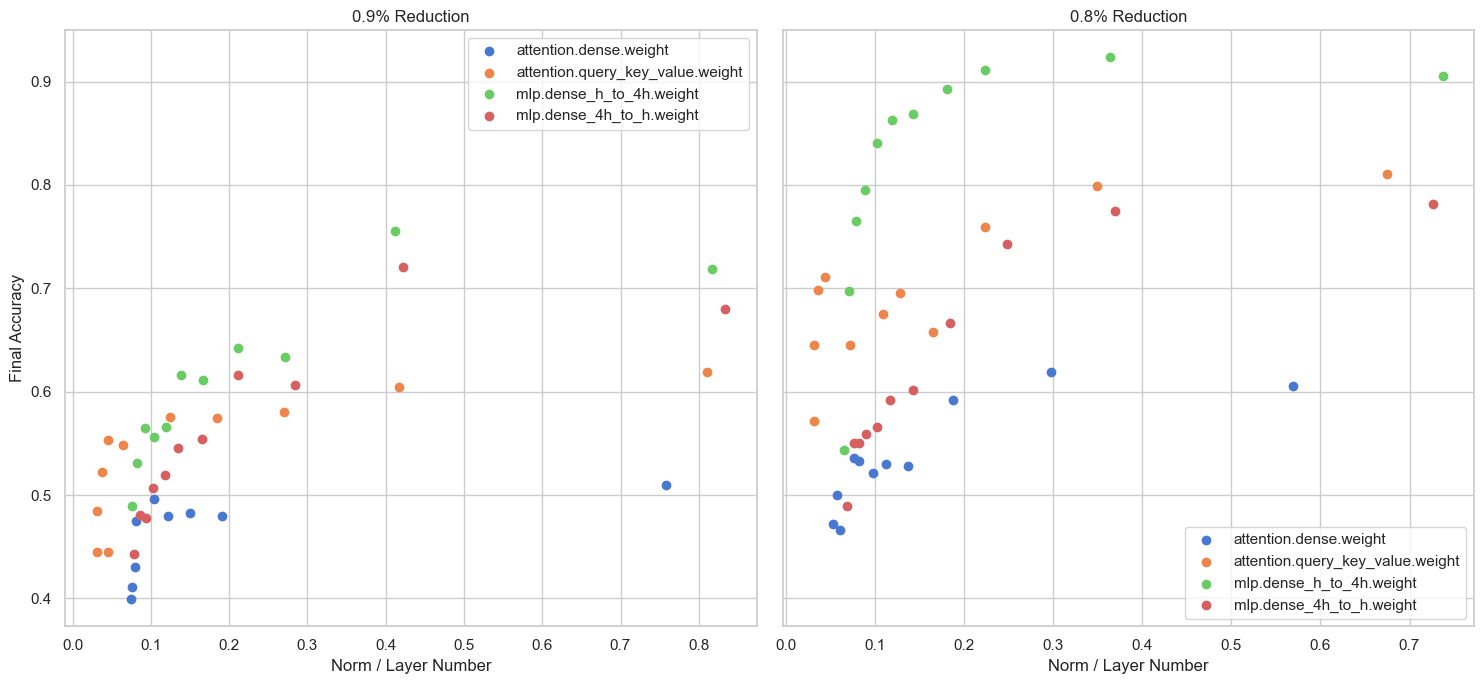

In [394]:
def plot_combined_norm_per_layer(df1):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharey=True)

    for rate, ax in zip([0.9, 0.8], axes):
        for block in df1['lname'].unique():
            data = df1[(df1['lname'] == block) & (df1['rate'] == rate)]
            ax.scatter(data['relative_error'] / data['lnum'], data['final_top1_accuracy'], label=f'{block}')
        
        ax.set_title(f'{rate}% Reduction')
        ax.set_xlabel('Norm / Layer Number')
        ax.legend()

    axes[0].set_ylabel('Final Accuracy')

    plt.tight_layout()
    plt.show()

plot_combined_norm_per_layer(df1)


In [ ]:
df2_pythia410, _ = print_tests("pythia410m", "none")
df1_pythia_410, _ = print_tests("pythia410m", "lr")
df2_roberta, _ = print_tests("roberta_base", "none")
df1_roberta, _ = print_tests("roberta_base", "lr")
df2_pythia160, _ = print_tests("pythia160m", "none")
df1_pythia160, _ = print_tests("pythia160m", "lr")

In [219]:
df["accuracy_diff"] = - df["edited_top1_accuracy"] + df["final_top1_accuracy"]
df["total_accuracy_diff"] = - df["original_top1_accuracy"] + df["final_top1_accuracy"]

df["cbrt_normalised_norm"] = df["norm"] / np.cbrt(df["lnum"])
df["normalised_norm"] = df["norm"] / df["lnum"]
df["cbrt_normalised_re"] = df["relative_error"] / np.cbrt(df["lnum"])
df["normalised_re"] = df["relative_error"] / df["lnum"]



In [220]:
df8 = df[df["rate"] == 0.8]
df9 = df[df["rate"] == 0.9]

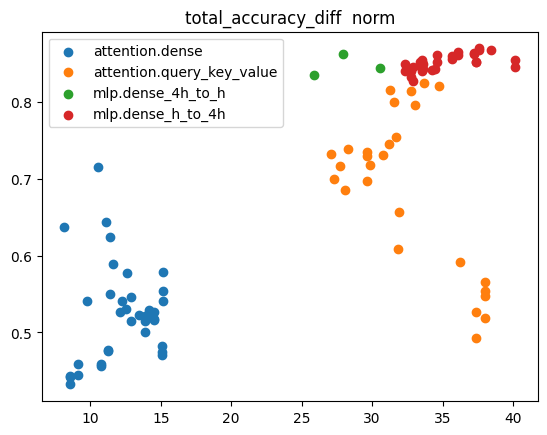

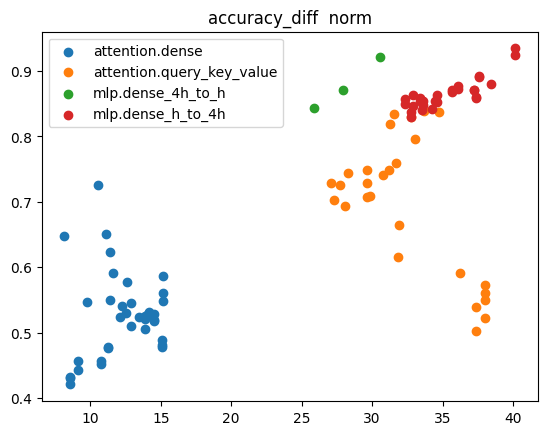

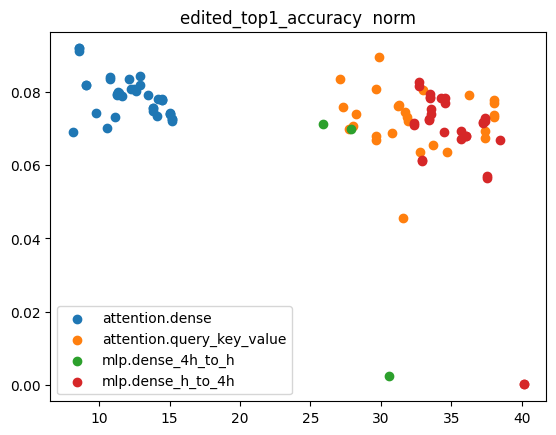

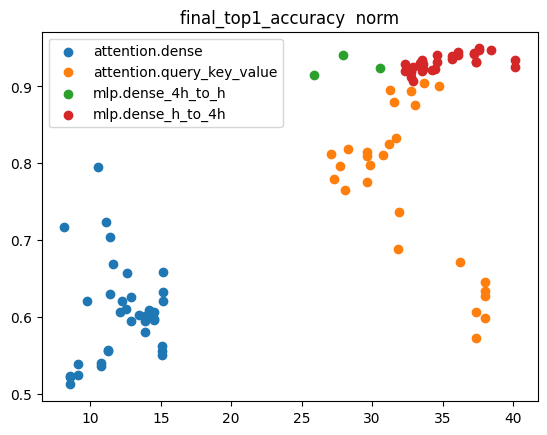

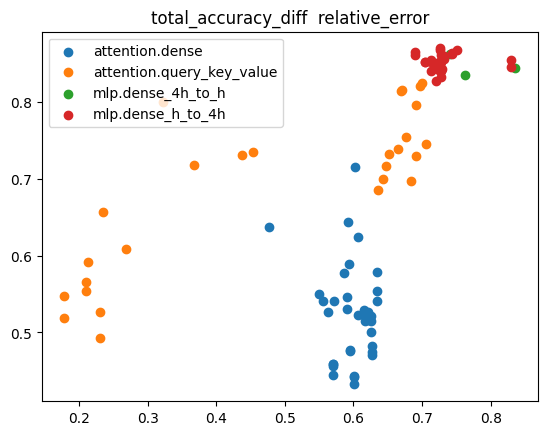

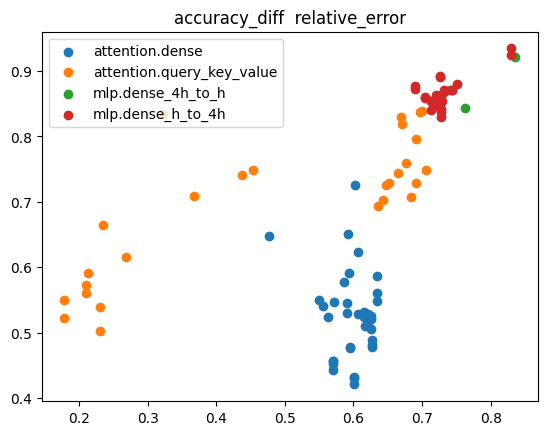

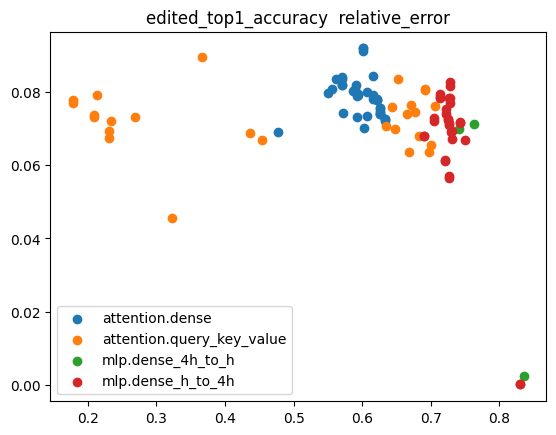

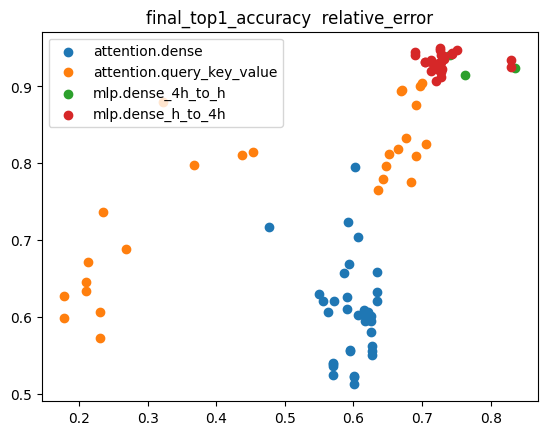

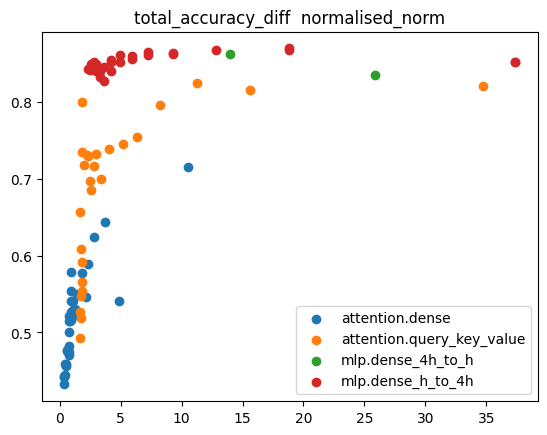

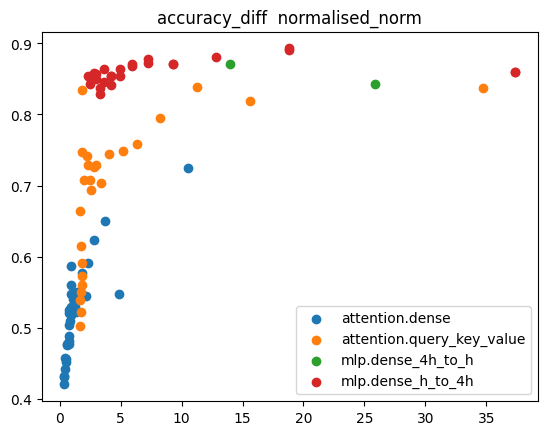

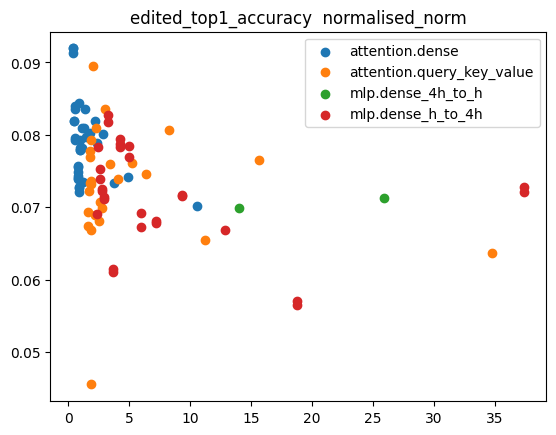

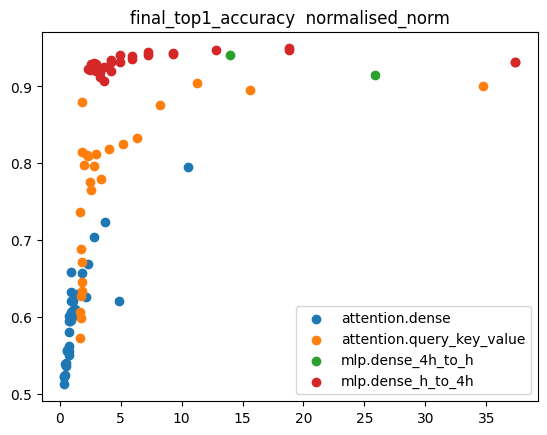

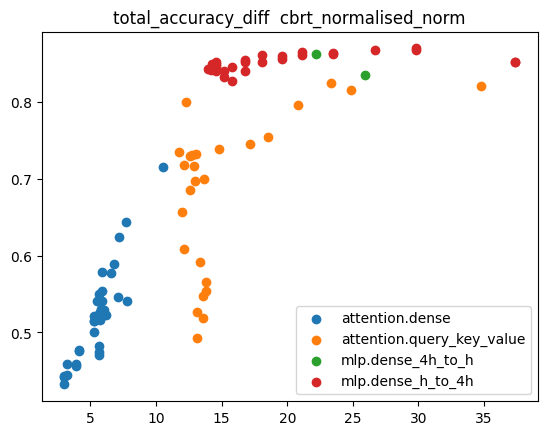

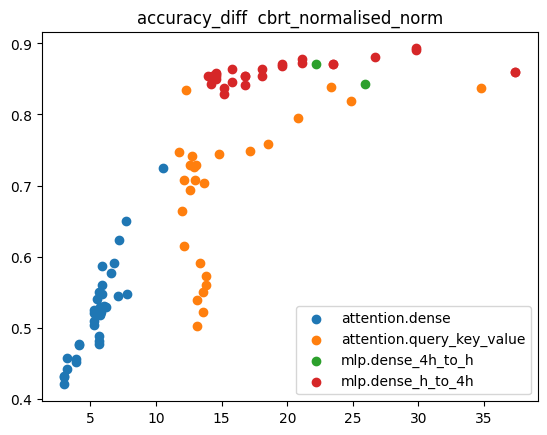

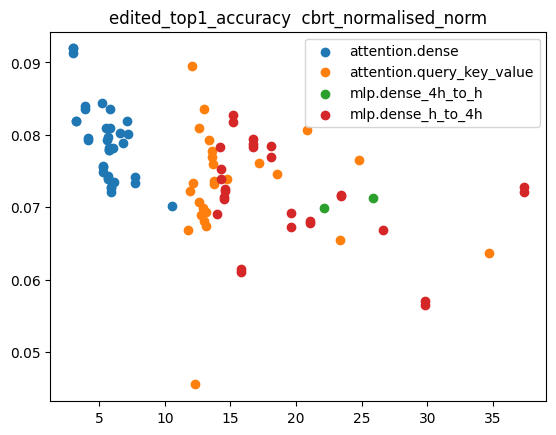

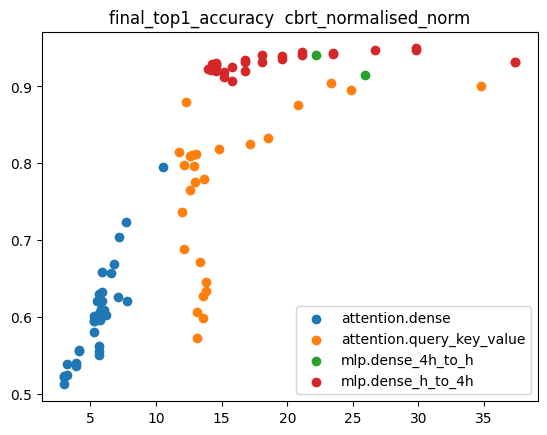

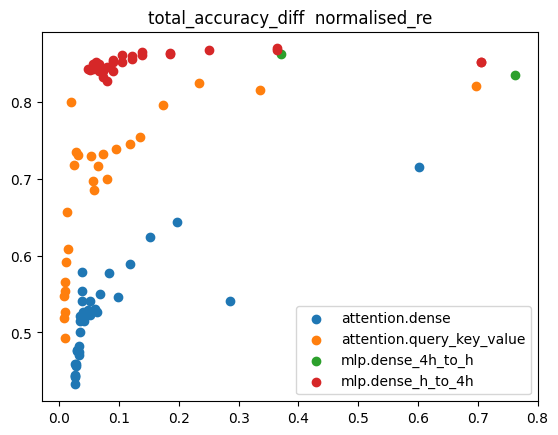

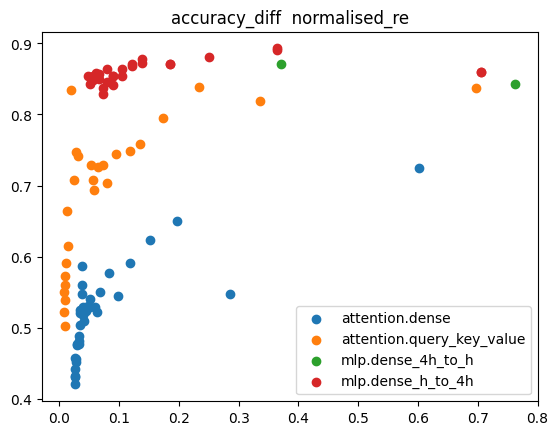

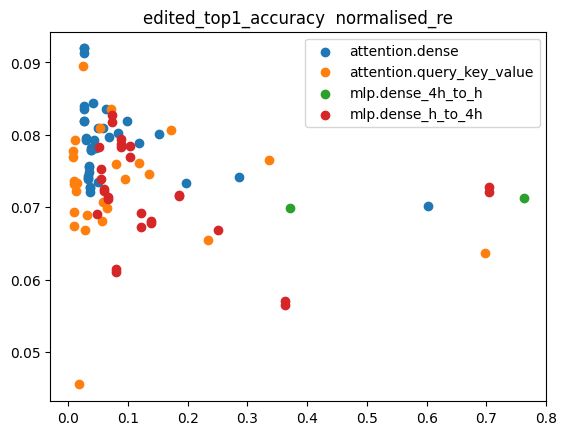

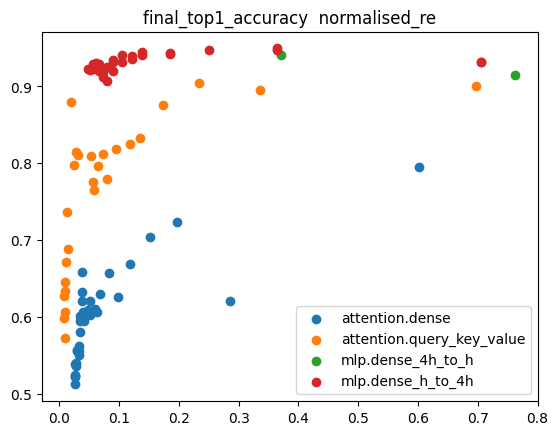

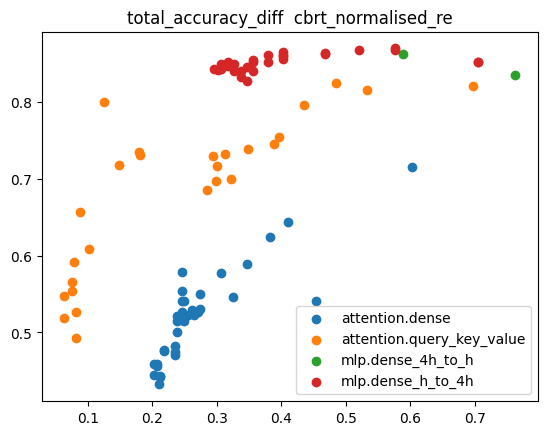

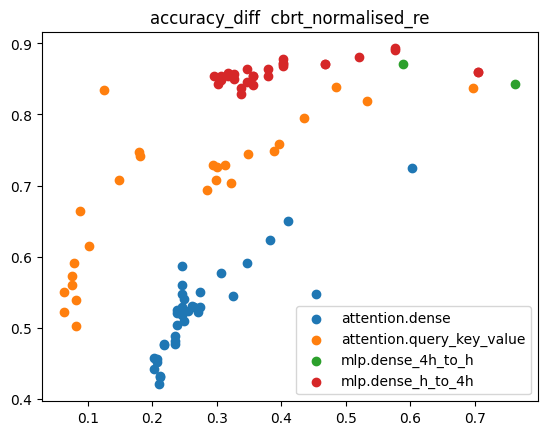

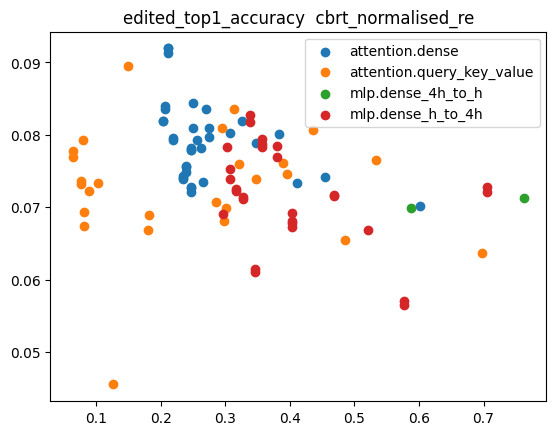

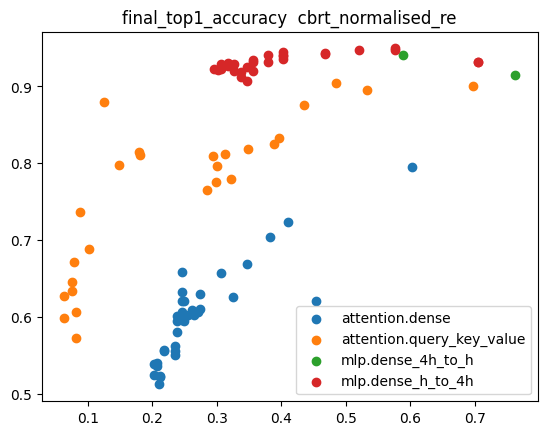

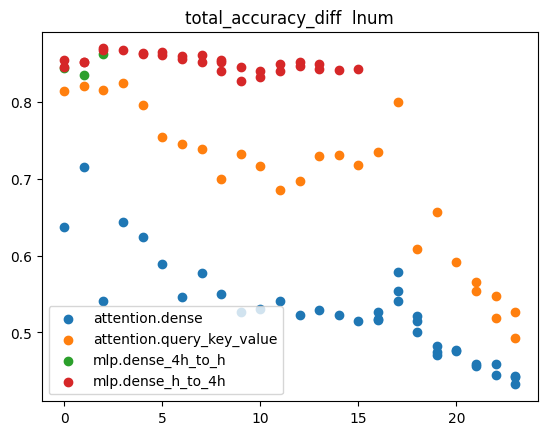

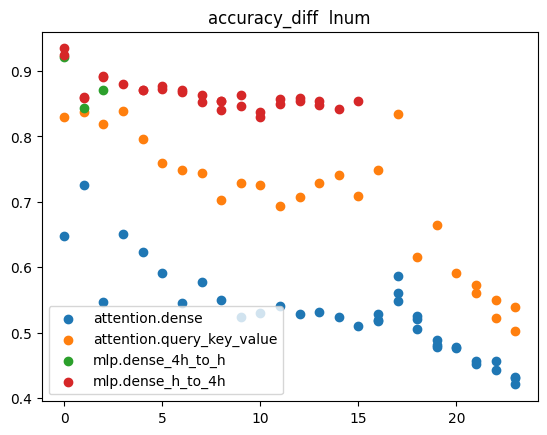

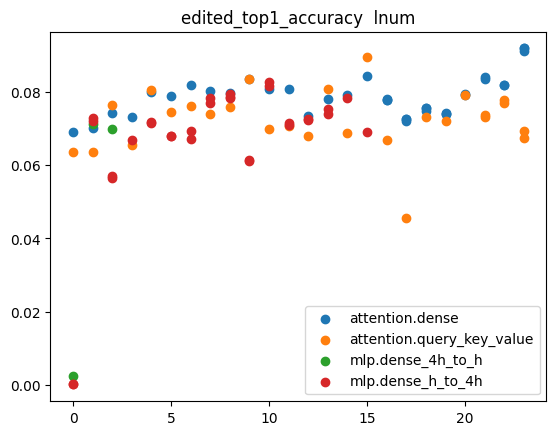

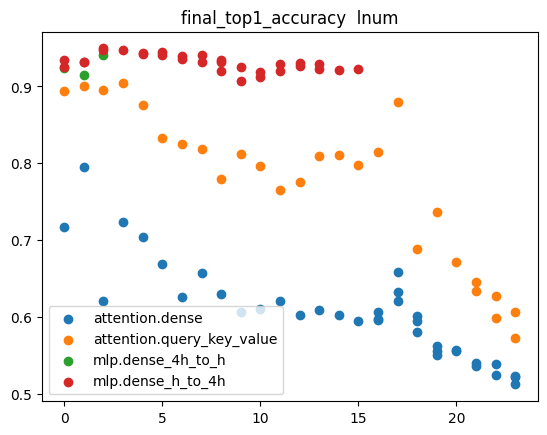

In [221]:
groups = df8.groupby('lname')

metrics = ["norm", "relative_error", "normalised_norm", "cbrt_normalised_norm", "normalised_re", "cbrt_normalised_re", "lnum"]
outputs = ["total_accuracy_diff", "accuracy_diff", "edited_top1_accuracy", "final_top1_accuracy"]





for m in metrics:
    for o in outputs:
        # Plot
        fig, ax = plt.subplots()
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
        for name, group in groups:
            ax.scatter(group[m], group[o], marker='o', label=name)
        ax.legend()
        plt.title(o + "  " + m)
        fig.savefig("outputs/plots/"+ o + "_vs_" + m + '.png')

        plt.show()

[[ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 3]
 [ 3]
 [ 3]
 [ 3]
 [ 3]
 [ 3]
 [ 3]
 [ 4]
 [ 4]
 [ 4]
 [ 4]
 [ 4]
 [ 4]
 [ 4]
 [ 4]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 6]
 [ 6]
 [ 6]
 [ 6]
 [ 6]
 [ 6]
 [ 6]
 [ 6]
 [ 7]
 [ 7]
 [ 7]
 [ 7]
 [ 7]
 [ 7]
 [ 7]
 [ 7]
 [ 8]
 [ 8]
 [ 8]
 [ 8]
 [ 8]
 [ 8]
 [ 8]
 [ 8]
 [ 8]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [11]
 [11]
 [11]
 [11]
 [11]
 [11]
 [11]
 [11]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [13]
 [13]
 [13]
 [13]
 [13]
 [13]
 [13]
 [13]
 [14]
 [14]
 [14]
 [14]
 [14]
 [14]
 [15]
 [15]
 [15]
 [15]
 [15]
 [15]
 [15]
 [15]
 [16]
 [16]
 [16]
 [16]
 [16]
 [16]
 [16]
 [16]
 [16]
 [17]
 [17]
 [17]
 [17]
 [17]
 [17]
 [17]
 [17]
 [17]
 [18]
 [18]
 [18]
 [18]
 [18]
 [18]
 [18]
 [18]
 [18]
 [19]
 [19]
 [19]
 [19]
 [19]
 [19]
 [19]
 [19]
 [19]
 [20]
 [20

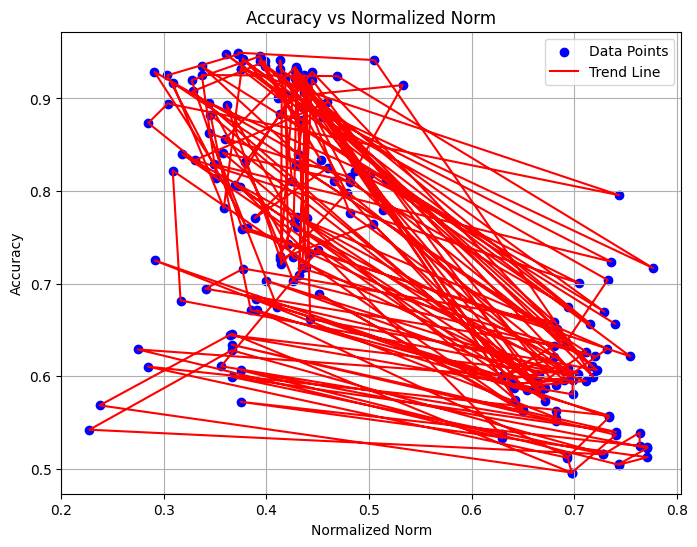

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Perform least squares regression with accuracy as the target and lnum as the independent variable
X = df['lnum'].values.reshape(-1, 1)  # Independent variable (lnum)
y = df['final_top1_accuracy'].values  # Dependent variable (accuracy)
print(X)
print(y)
model = LinearRegression()
model.fit(X, y)

# Coefficients from the regression
slope = model.coef_[0]
intercept = model.intercept_

# Normalize the norm column using the coefficients
df['normalized_norm'] = df['norm'] * slope + intercept

# Plot accuracy vs normalized norm
plt.figure(figsize=(8, 6))
plt.scatter(df['normalized_norm'], df['final_top1_accuracy'], color='blue', label='Data Points')
plt.plot(df['normalized_norm'], df['final_top1_accuracy'], color='red', linestyle='-', label='Trend Line')
plt.xlabel('Normalized Norm')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Normalized Norm')
plt.legend()
plt.grid(True)
plt.show()


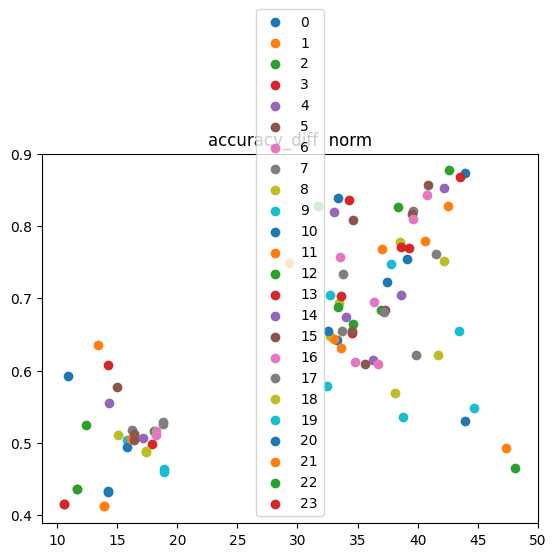

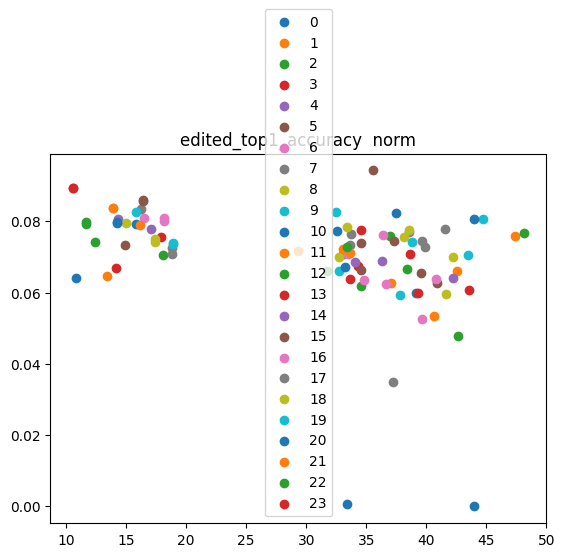

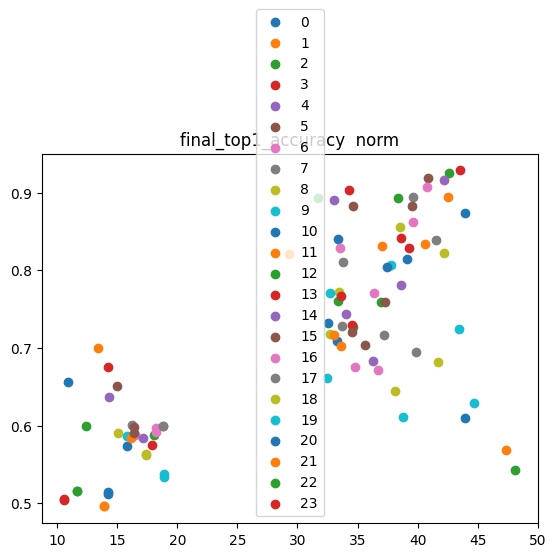

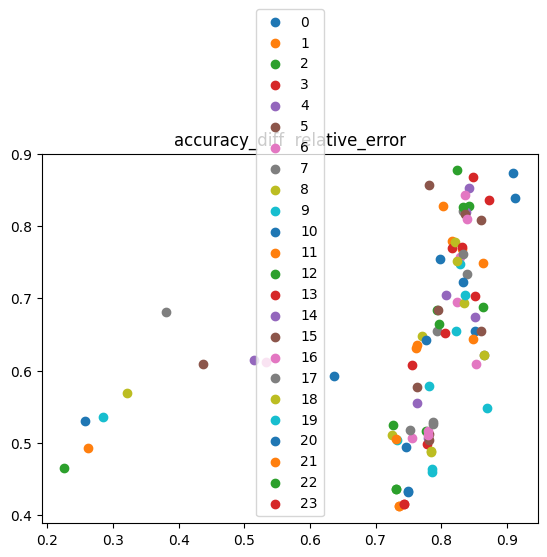

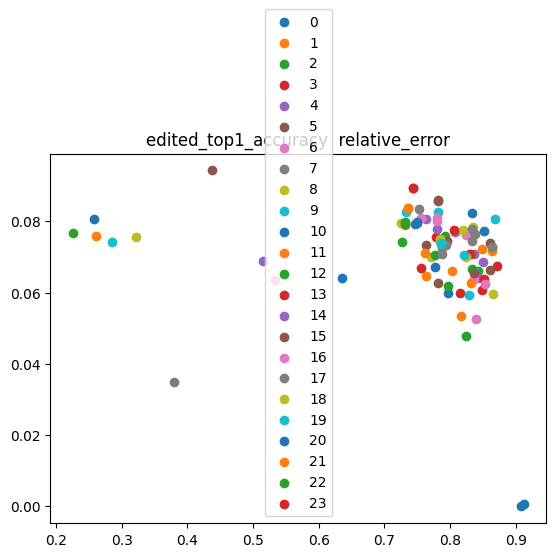

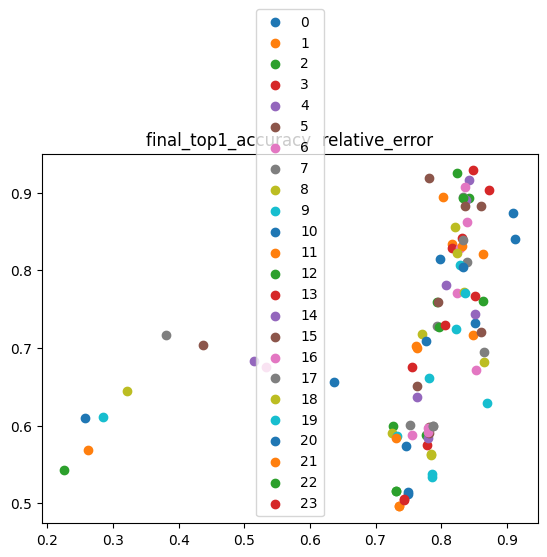

In [212]:
groups = df9.groupby('lnum')

metrics = ["norm", "relative_error"]
outputs = ["accuracy_diff", "edited_top1_accuracy", "final_top1_accuracy"]

for m in metrics:
    for o in outputs:
        # Plot
        fig, ax = plt.subplots()
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
        for name, group in groups:
            ax.scatter(group[m], group[o], marker='o', label=name)
        ax.legend()
        plt.title(o + "  " + m)
        fig.savefig("outputs/plots/"+ o + "_vs_" + m + '.png')

        plt.show()

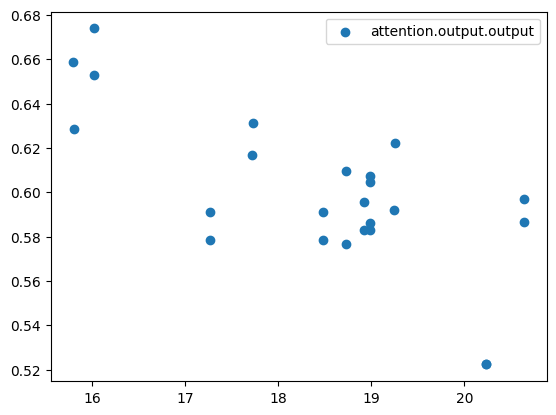

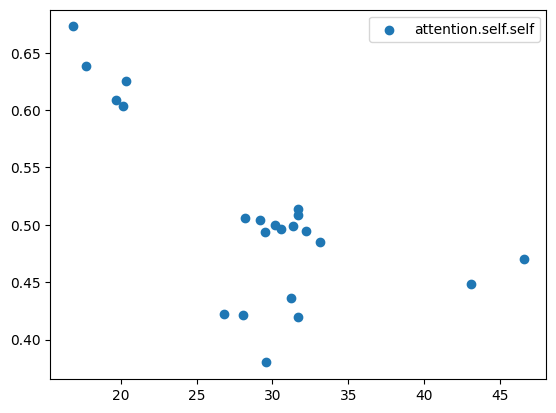

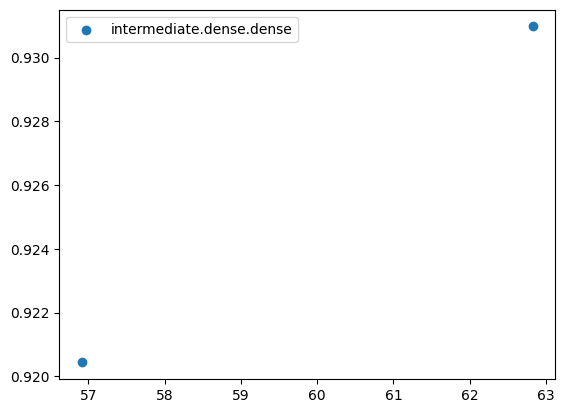

In [125]:
groups = df8.groupby('lname')


regressor = LinearRegression()

for name, group in groups:
    plt.scatter(group["norm"], group["final_top1_accuracy"], marker='o', label=name)
    plt.legend()
    plt.show()


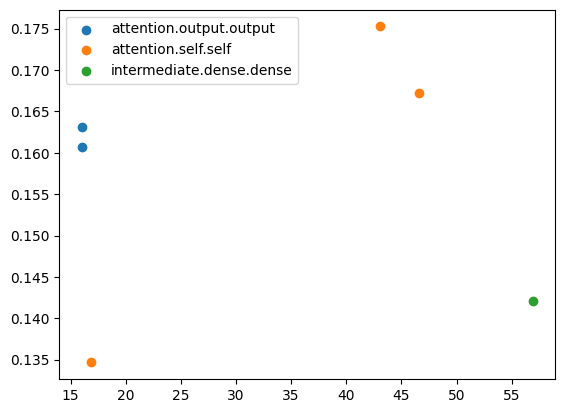

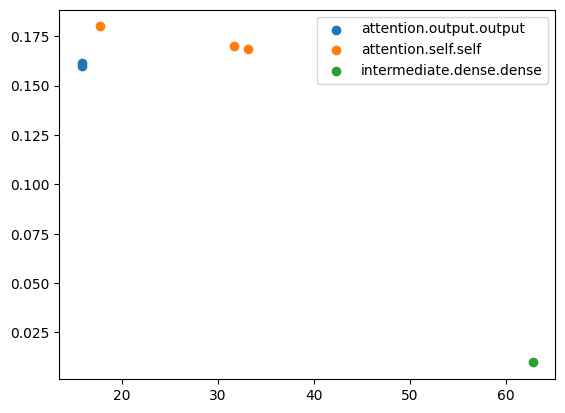

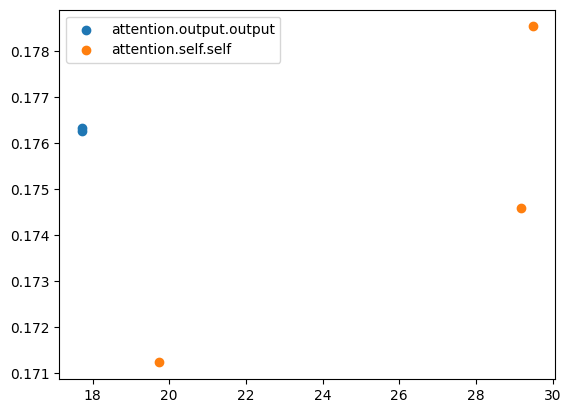

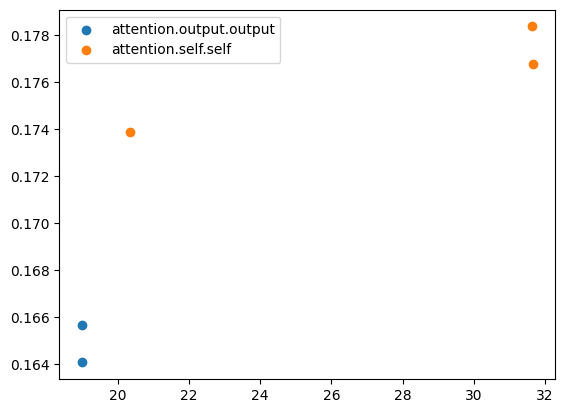

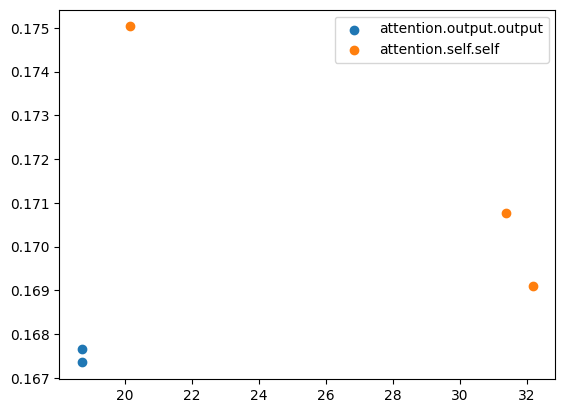

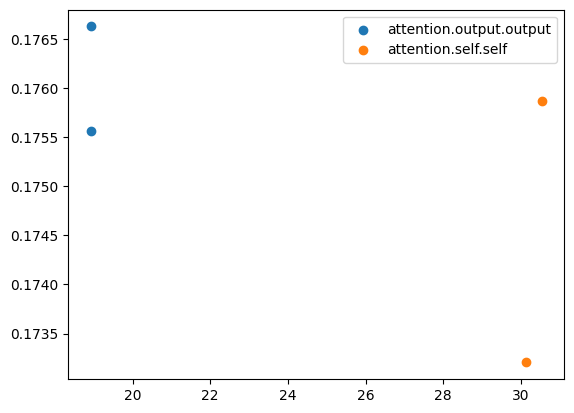

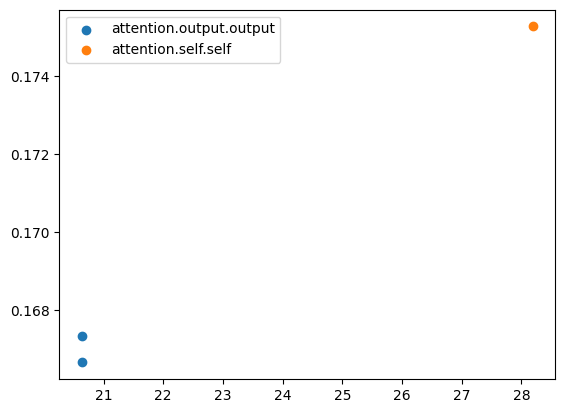

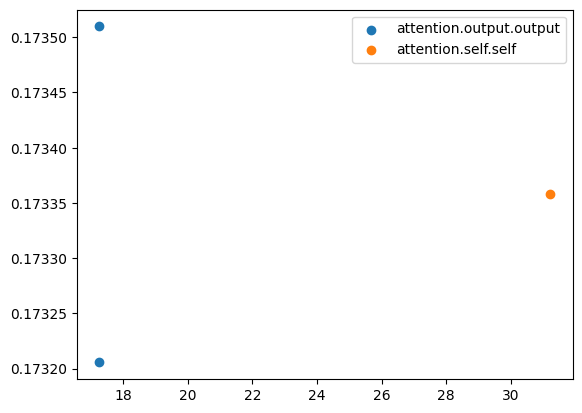

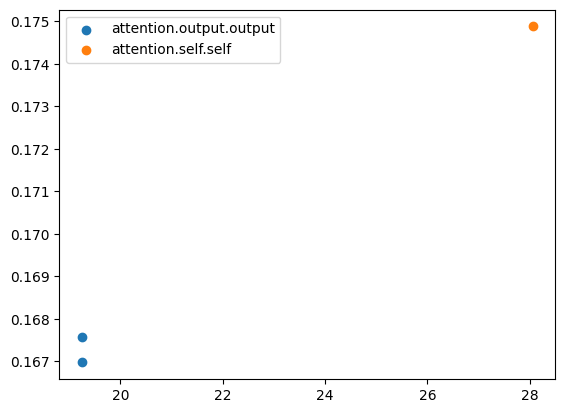

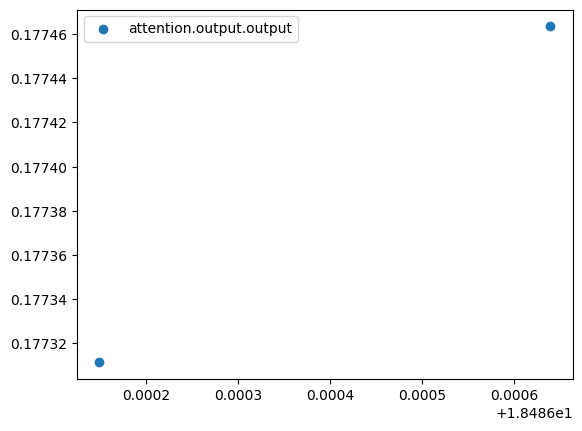

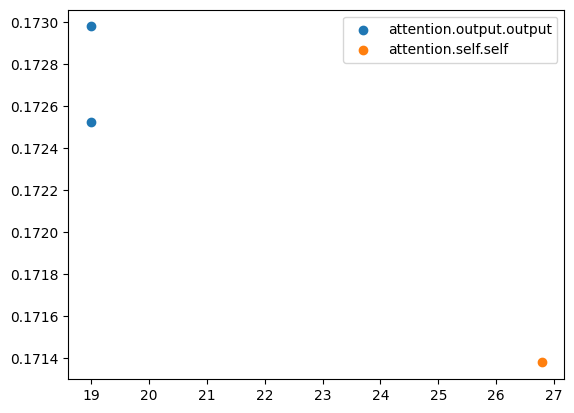

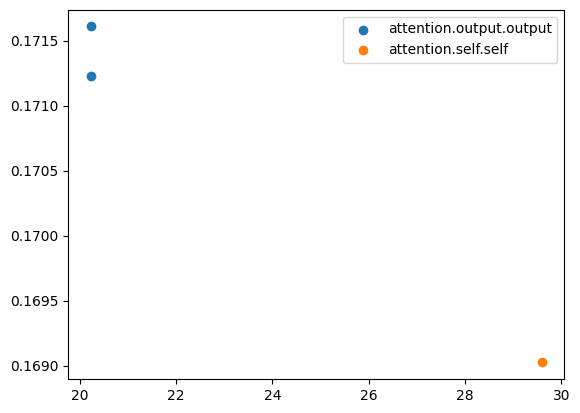

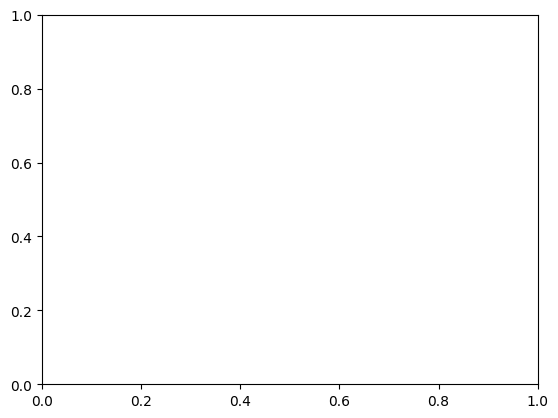

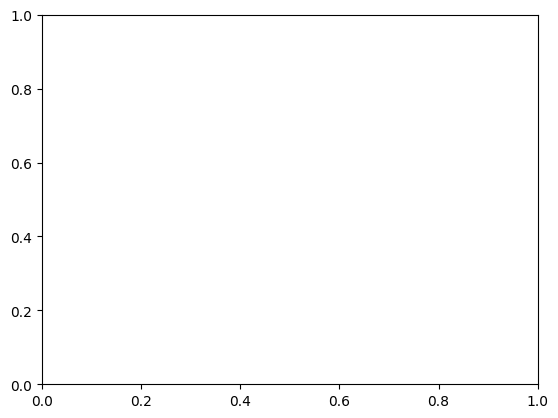

In [127]:
df_lnum0 = df[df["lnum"] == 0]

for l in range(14):
    df_lnum = df8[df8["lnum"] == l]
    groups = df_lnum.groupby('lname')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.scatter(group["norm"], group["edited_top1_accuracy"], marker='o', label=name)
        ax.legend()
    plt.show()

